In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
# ics = od+expand(config['lr']['cerberus']['ics'], species='human')[0]
# ics = od+expand(config['lr']['talon']['ics'], species='human')[0]
talon_gtf = od+expand(config['lr']['talon']['gtf'], species='human')[0]
talon_filt_ab = od+expand(config['lr']['talon']['filt_ab'], species='human')[0]
ref_gtf = od+expand(config['ref']['gtf'], species='human')[0]
ref_ics = od+expand(config['ref']['cerberus']['ics'], species='human')[0]


In [129]:
def add_ss_type_to_intron(df):
    """
    Given a bed-style df, add "ss_3" and "ss_5" columns to 
    indicate which splice site each coordinate is used
    
    Parameters:
        df (pandas DataFrame): Bed-style DF of introns
    
    Returns:
        df (pandas DataFrame): Bed-style DF of introns w/ ss_3 and ss_5 columns added
    """
    
    df['ss_5'] = np.nan
    df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
    df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
    df['ss_3'] = np.nan
    df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
    df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    return df
    

def intron_to_ss(df, id_cols=None):
    """
    Get splice site coordinates from intron coordinates in bed format
    
    Parameters:
        df (pandas DataFrame): Pandas DF of intron coordinates in bed format
        id_cols (None or list of str): List of columns to use as ss identifier 
            during melt, otherwise None
            
    Returns:
        df (pandas DataFrame): Pandas DF of splice site coordinates in semi 
            bed format (ie no end positions, just starts, as these are single bp)
    """
    
    
    # since these are intron coords, the start defines a 3' ss 
    # and the end defines a 5' ss.
    # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
#     df['ss_5'] = np.nan
#     df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
#     df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
#     df['ss_3'] = np.nan
#     df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
#     df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    df = add_ss_type_to_intron(df)
    
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    df.drop(['Start', 'End'], axis=1, inplace=True)
    
    if id_cols:
        id_cols += ['Chromosome', 'Strand']
    else:
        id_cols = ['Chromosome', 'Strand']
        
    df = df.melt(id_vars=id_cols,
                 var_name='ss_type',
                 value_name='Start')
    
    # remove duplicates, which would result from the same 
    # ss being used in different sjs
    df = df.drop_duplicates()

    return df
        
def get_source_table(df):
    """
    Get a melted form table for each entry in a tss, ic, or tes table
    for each form of support for each triplet feature.
    
    Parameters:
        df (pandas DataFrame): DataFrame of tsss, ics, or tess
    
    Returns:
        df (pandas DataFrame): Long-form DataFrame of support for each tss, ic, or tes
    """
    keep_cols = ['Name', 'source']
    df = df[keep_cols].copy(deep=True)
    df['list_source'] = df.source.str.split(',')
    df = df.explode('list_source')
    df.drop('source', axis=1, inplace=True)
    
    return df

# chatgpt wrote this for me thanx chatgpt
def sequential_pairs(x, how='sj'):
    """
    Get sequential pairs of tuples in list.
    Example: [1,2,3,4] -> [(1,2),(3,4)]
    """
    p = []
    if how == 'sj' or how == 'ss':
        for i in range(0, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    elif how == 'exon':
        for i in range(1, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    return p

def explode_ic(ic, how):
    """
    Explode an ic df to long form with splice junction entries
    """
    # remove the monoexonic entries    
    ic = ic.loc[~(ic.Coordinates == '-')]
        
    # remove the two-exon entries if we're getting exons
    if how == 'exon':
        ic = ic.loc[~(ic.Coordinates.str.count('-')==1)]
    
    # explode into series of ss coords
    keep_cols = ['Chromosome', 'Coordinates',
                 'Strand', 'gene_id',
                 'Name']
    df = ic.copy(deep=True)
    df = df[keep_cols]
    df['ss_coords'] = df.Coordinates.str.split('-')
    
    # get pairs of sss to form sjs
    df['sj_coords'] = df.ss_coords.apply(sequential_pairs, how=how)
    df = df.explode('sj_coords')
    df.drop(['Coordinates', 'ss_coords'], axis=1, inplace=True)
                
    return df

def get_ss_sj_from_ic(ic, ref_sources, how):
    ic = ic.copy(deep=True)

    # get coords of each splice site in each splice junction
    df = explode_ic(ic, how=how)
    df['Start'] = df['sj_coords'].str[0].astype(int)
    df['End'] = df['sj_coords'].str[1].astype(int)
    df.drop('sj_coords', axis=1, inplace=True)

    # label sss as 5' or 3' and melt
    if how == 'ss':
        # assert len(df.loc[(df.Start>df.End)&(df.Strand=='+')].index) == 0
        # # since these are intron coords, the start defines a 3' ss 
        # # and the end defines a 5' ss
        # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
        # id_cols = ['Chromosome', 'Strand', 'gene_id', 'Name']
        # df = df.melt(id_vars=id_cols,
        #              var_name='ss_type',
        #              value_name='Start')
        df = intron_to_ss(df, ['gene_id', 'Name'])
        
    # for sjs, reorder according to min and max coords
    # in bed standard format
    elif how == 'sj' or how == 'exon':
        df['temp_Start'] = df.Start
        df['temp_End'] = df.End
        df['Start'] = df[['temp_Start', 'temp_End']].min(axis=1)
        df['End'] = df[['temp_Start', 'temp_End']].max(axis=1)
        df.drop(['temp_Start', 'temp_End'], axis=1, inplace=True)
             
    # df to hold ic to ss or sj info 
    ic_df = df.copy(deep=True)
    
    # merge source info in w/ coord info
    df2 = get_source_table(ic)
    df = df.merge(df2, how='left', on=['Name'])
    
    # figure out novelty and source of each ss / sj
    df.drop('Name', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    gb_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        gb_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        gb_cols += ['End']
    df.rename({'list_source': 'source'},
              axis=1, inplace=True)
    df['novelty'] = df.source.isin(ref_sources).map({True: 'Known',
                                                     False: 'Novel'})
    df = df.groupby(gb_cols).agg(','.join).reset_index()
    df = cerberus.update_novelty(df)
    
    # add novelty and support information to the ic / (ss or sj) df
    merge_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        merge_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        merge_cols += ['End']
    ic_df = ic_df.merge(df, how='left',
                        on=merge_cols)
    
    return df, ic_df

def get_exon_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'exon')


def get_sj_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj')

def get_ss_from_ic(ic, ref_sources):
    """
    Get a splice site table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice site
        ic_df (pandas DataFrame): DataFrame with entries for each splice site /
            intron chain combination
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'ss')       

In [130]:
def get_fusion_sj_table(ab, ics, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    df = pd.read_csv(ics, sep='\t')
    df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    df['source'] = 'lapa'
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    # known_df = df.loc[df.gene_id.isin(known_gids)]    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_sj_ic_df = get_sj_from_ic(fusion_df, ['lapa'])
    f_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_sj_ic_df = get_sj_from_ic(known_df, ['lapa'])
    k_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_sj_ic_df = f_sj_ic_df.merge(k_sj_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                              suffixes=('', '_known'))
    f_sj_ic_df['known'] = False
    f_sj_ic_df.loc[f_sj_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sjs / ic
    temp = f_sj_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
    temp['sj'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+temp.End.astype(str)
    temp = temp[['Name', 'sj']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'sj':'n_total_sj'}, axis=1, inplace=True)
    temp.head()
    
    # splice junctions / ic from each gene
    temp2 = f_sj_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    temp2.drop('End', axis=1, inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_sj'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_sj', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_sj', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sjs / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_sj']/temp5['n_total_sj'])*100
    return f_sj_ic_df, temp5

In [131]:
def get_fusion_ss_table(ab, gtf, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    # df = pd.read_csv(ics, sep='\t')
    # df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    # df['source'] = 'lapa'
    df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True)
    df = cerberus.get_ic(df)
    df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
    df['source'] = 'lapa'
    
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_ss_ic_df = get_ss_from_ic(fusion_df, ['lapa'])
    f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
    k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                              suffixes=('', '_known'))
    f_ss_ic_df['known'] = False
    f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sss / ic
    temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
    temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
    temp = temp[['Name', 'ss']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
    temp.head()
    
    # splice sites / ic from each gene
    temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_ss', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sss / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100
    return f_ss_ic_df, temp5, fusion_df

## 231208 another

In [341]:
include_novel=False
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [342]:
# check when we hit annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
fusion_gids = rt_df.gid_stable.tolist()

In [351]:
known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [353]:
df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
df['known'] = False
df.loc[df.Name_known.notnull(), 'known'] = True

In [357]:
# number of unique sss per transcript; only known
k_df = k_ss_ic_df.copy(deep=True)
k_df['ss_id'] = k_df.Name+k_df.Chromosome+k_df.Strand+k_df.Start.astype(str)
k_df['n_ss_per_t'] =  k_df[['ss_id', 'Name']].groupby('Name').transform('nunique')

In [355]:
# number of unique sss per transcript
df['ss_id'] = df.Name+df.Chromosome+df.Strand+df.Start.astype(str)
df['n_ss_per_t'] =  df[['ss_id', 'Name']].groupby('Name').transform('nunique')

,gene_id,Name,Chromosome,Strand,ss_type,Start,gene_id_known,Name_known,known,ss_id,n_ss_per_t
0,SIRV1.1,SIRV1.1-SIRV101,SIRV1,-,ss_5,10444.0,SIRV1,SIRV1_4,True,SIRV1.1-SIRV101SIRV1-10444.0,10
1,SIRV1.1,SIRV1.1-SIRV101,SIRV1,-,ss_5,10282.0,SIRV1,SIRV1_3,True,SIRV1.1-SIRV101SIRV1-10282.0,10
2,SIRV1.1,SIRV1.1-SIRV101,SIRV1,-,ss_5,10282.0,SIRV1,SIRV1_4,True,SIRV1.1-SIRV101SIRV1-10282.0,10
3,SIRV1.1,SIRV1.1-SIRV101,SIRV1,-,ss_5,10282.0,SIRV1,SIRV1_6,True,SIRV1.1-SIRV101SIRV1-10282.0,10
4,SIRV1.1,SIRV1.1-SIRV101,SIRV1,-,ss_5,10282.0,SIRV1,SIRV1_7,True,SIRV1.1-SIRV101SIRV1-10282.0,10


In [368]:
# number of known sss per transcript
df['n_known_ss_per_t'] = df[['ss_id', 'known', 'Name']].groupby(['Name', 'known']).transform('nunique')

In [369]:
df.loc[df.Name=='TALONT000212745']

,gene_id,Name,Chromosome,Strand,ss_type,Start,gene_id_known,Name_known,known,ss_id,n_ss_per_t,n_known_ss_per_t
914,SIRV5.1,TALONT000212745,SIRV5,+,ss_5,1149.0,SIRV5,SIRV5_3,True,TALONT000212745SIRV5+1149.0,30,29
915,SIRV5.1,TALONT000212745,SIRV5,+,ss_5,1149.0,SIRV5,SIRV5_4,True,TALONT000212745SIRV5+1149.0,30,29
916,SIRV5.1,TALONT000212745,SIRV5,+,ss_5,1149.0,SIRV5,SIRV5_5,True,TALONT000212745SIRV5+1149.0,30,29
917,SIRV5.1,TALONT000212745,SIRV5,+,ss_5,1149.0,SIRV5,SIRV5_6,True,TALONT000212745SIRV5+1149.0,30,29
918,SIRV5.1,TALONT000212745,SIRV5,+,ss_5,1149.0,SIRV5,SIRV5_7,True,TALONT000212745SIRV5+1149.0,30,29
...,...,...,...,...,...,...,...,...,...,...,...,...
8453818,SIRV5.1,TALONT000212745,SIRV5,+,ss_3,10858.0,SIRV5,SIRV5_7,True,TALONT000212745SIRV5+10858.0,30,29
8453819,SIRV5.1,TALONT000212745,SIRV5,+,ss_3,10858.0,SIRV5,SIRV5_8,True,TALONT000212745SIRV5+10858.0,30,29
8453820,SIRV5.1,TALONT000212745,SIRV5,+,ss_3,10858.0,SIRV5,SIRV5_9,True,TALONT000212745SIRV5+10858.0,30,29
8453821,SIRV5.1,TALONT000212745,SIRV5,+,ss_3,10858.0,SIRV5,SIRV5_10,True,TALONT000212745SIRV5+10858.0,30,29


In [370]:
# len(df.loc[df.Name=='TALONT000212745'].ss_id.unique().tolist())

In [367]:
# df.loc[df.known==False].head()
df.loc[df.Name=='TALONT000212745'][['ss_id', 'known', 'n_known_ss_per_t']].drop_duplicates()

,ss_id,known,n_known_ss_per_t
914,TALONT000212745SIRV5+1149.0,True,160
921,TALONT000212745SIRV5+2033.0,True,160
927,TALONT000212745SIRV5+2156.0,True,160
932,TALONT000212745SIRV5+2315.0,True,160
937,TALONT000212745SIRV5+3404.0,True,160
943,TALONT000212745SIRV5+3640.0,False,1
944,TALONT000212745SIRV5+5450.0,True,160
949,TALONT000212745SIRV5+5626.0,True,160
954,TALONT000212745SIRV5+6169.0,True,160
959,TALONT000212745SIRV5+6452.0,True,160


## 231207 fix messed up gene assignments
* Ok pls let's try again

In [193]:
include_novel=False
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [194]:
# check when we hit annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
fusion_gids = rt_df.gid_stable.tolist()

In [195]:
known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [196]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [340]:
# total sss / transcript from the annotated transcripts
k_total_ss = k_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
k_total_ss['ss'] = k_total_ss.Name+k_total_ss.Chromosome+k_total_ss.Strand+k_total_ss.Start.astype(str)
k_total_ss = k_total_ss[['Name', 'ss']]
k_total_ss = k_total_ss.groupby('Name').nunique().reset_index()
k_total_ss.rename({'ss':'n_total_annot_ss'}, axis=1, inplace=True)
k_total_ss.head()

,Name,n_total_ss
0,ENSG00000000003_1,14
1,ENSG00000000003_2,12
2,ENSG00000000003_3,12
3,ENSG00000000003_4,10
4,ENSG00000000003_5,10


In [295]:
# total # splice sss / transcript
temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
temp = temp[['Name', 'ss']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
temp.head()

,Name,n_total_ss
0,ENST00000000233.9,10
1,ENST00000000412.7,12
2,ENST00000000442.10,12
3,ENST00000001008.5,18
4,ENST00000001146.6,10


In [301]:
# total # known splice sss / transcript
known_n_ss = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'known']].copy(deep=True)
known_n_ss = known_n_ss.loc[known_n_ss.known==True]
known_n_ss.drop('known', axis=1, inplace=True)
known_n_ss['ss'] = known_n_ss.Name+known_n_ss.Chromosome+known_n_ss.Strand+known_n_ss.Start.astype(str)
known_n_ss = known_n_ss[['Name', 'ss']]
known_n_ss = known_n_ss.groupby('Name').nunique().reset_index()
known_n_ss.rename({'ss':'n_total_known_ss'}, axis=1, inplace=True)
known_n_ss.head()

,Name,n_total_known_ss
0,ENST00000000233.9,10
1,ENST00000000412.7,12
2,ENST00000000442.10,12
3,ENST00000001008.5,18
4,ENST00000001146.6,10


In [206]:
# splice sites / transcript that are from each gene
temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp2.drop_duplicates(inplace=True)
if include_novel == True:
    dropna = False
else:
    dropna = True
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)

# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_ss', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()

,Name,known,gene_id,n_ss,rank
19537,ENST00000375254.7,True,ENSG00000127481,210,1
17000,ENST00000369393.7,True,ENSG00000112159,202,1
19328,ENST00000374695.7,True,ENSG00000142798,192,1
3172,ENST00000261609.11,True,ENSG00000128731,184,1
1694,ENST00000243077.7,True,ENSG00000123384,176,1


In [207]:
# add some info
temp2['rt_gene'] = temp2.gene_id.isin(fusion_gids)
temp2 = temp2.merge(talon_df[['annot_transcript_id', 'transcript_novelty', 'gene_novelty']], 
                    how='left', left_on='Name', right_on='annot_transcript_id')
temp2.head()


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty
0,ENST00000375254.7,True,ENSG00000127481,210,1,False,ENST00000375254.7,Known,Known
1,ENST00000369393.7,True,ENSG00000112159,202,1,False,ENST00000369393.7,Known,Known
2,ENST00000374695.7,True,ENSG00000142798,192,1,False,ENST00000374695.7,Known,Known
3,ENST00000261609.11,True,ENSG00000128731,184,1,False,ENST00000261609.11,Known,Known
4,ENST00000243077.7,True,ENSG00000123384,176,1,False,ENST00000243077.7,Known,Known


In [253]:
# get number of sss supported by rt genes for each transcript
rt_ss = temp2.loc[temp2.rt_gene==True]
rt_ss = rt_ss[['Name', 'n_ss']]
rt_ss.rename({'n_ss':'n_rt_ss'}, axis=1, inplace=True)
rt_ss.head()

,Name,n_rt_ss
747,ENST00000359526.8,80
773,ENST00000592705.5,80
794,TALONT000511426,79
857,ENST00000340748.8,78
862,ENST00000644137.1,78


In [208]:
# get number of genes that have overlapping sss for each transcript
temp3 = temp2[['Name', 'gene_id']]
temp3 = temp3.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
temp3.columns = temp3.columns.map(''.join)
temp3.columns = ['Name', 'n_genes', 'gene_ids']
print(len(temp3.loc[temp3.n_genes>1].index))
print(len(temp3.index))
temp3.head()
temp2 = temp2.merge(temp3, how='left', on='Name')
temp2.head()

13210
163083


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids
0,ENST00000375254.7,True,ENSG00000127481,210,1,False,ENST00000375254.7,Known,Known,1,ENSG00000127481
1,ENST00000369393.7,True,ENSG00000112159,202,1,False,ENST00000369393.7,Known,Known,1,ENSG00000112159
2,ENST00000374695.7,True,ENSG00000142798,192,1,False,ENST00000374695.7,Known,Known,1,ENSG00000142798
3,ENST00000261609.11,True,ENSG00000128731,184,1,False,ENST00000261609.11,Known,Known,1,ENSG00000128731
4,ENST00000243077.7,True,ENSG00000123384,176,1,False,ENST00000243077.7,Known,Known,1,ENSG00000123384


In [210]:
# get number of genes that have overlapping sss for each transcript,
# w/o the rt genes
print(len(temp2.index))
temp4 = temp2.loc[temp2.rt_gene==False][['Name', 'gene_id']]
print(len(temp4.index))

temp4 = temp4.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
temp4.columns = temp4.columns.map(''.join)
temp4.columns = ['Name', 'n_genes_no_rt', 'gene_ids_no_rt']
print(len(temp4.loc[temp4.n_genes_no_rt==1].index))
print(len(temp4.index))
temp4.head()
temp2 = temp2.merge(temp4, how='left', on='Name')
temp2.head()

178815
167470
159309
162819


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
0,ENST00000375254.7,True,ENSG00000127481,210,1,False,ENST00000375254.7,Known,Known,1,ENSG00000127481,1.0,ENSG00000127481
1,ENST00000369393.7,True,ENSG00000112159,202,1,False,ENST00000369393.7,Known,Known,1,ENSG00000112159,1.0,ENSG00000112159
2,ENST00000374695.7,True,ENSG00000142798,192,1,False,ENST00000374695.7,Known,Known,1,ENSG00000142798,1.0,ENSG00000142798
3,ENST00000261609.11,True,ENSG00000128731,184,1,False,ENST00000261609.11,Known,Known,1,ENSG00000128731,1.0,ENSG00000128731
4,ENST00000243077.7,True,ENSG00000123384,176,1,False,ENST00000243077.7,Known,Known,1,ENSG00000123384,1.0,ENSG00000123384


In [211]:
temp2.head()

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
0,ENST00000375254.7,True,ENSG00000127481,210,1,False,ENST00000375254.7,Known,Known,1,ENSG00000127481,1.0,ENSG00000127481
1,ENST00000369393.7,True,ENSG00000112159,202,1,False,ENST00000369393.7,Known,Known,1,ENSG00000112159,1.0,ENSG00000112159
2,ENST00000374695.7,True,ENSG00000142798,192,1,False,ENST00000374695.7,Known,Known,1,ENSG00000142798,1.0,ENSG00000142798
3,ENST00000261609.11,True,ENSG00000128731,184,1,False,ENST00000261609.11,Known,Known,1,ENSG00000128731,1.0,ENSG00000128731
4,ENST00000243077.7,True,ENSG00000123384,176,1,False,ENST00000243077.7,Known,Known,1,ENSG00000123384,1.0,ENSG00000123384


In [214]:
print(len(temp2.loc[(temp2.n_genes!=temp2.n_genes_no_rt)&(temp2.n_genes_no_rt>1)].index))
temp2.loc[(temp2.n_genes!=temp2.n_genes_no_rt)&(temp2.n_genes_no_rt>1)].head()

2447


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
1021,ENST00000504764.5,True,ENSG00000248672,76,1,True,ENST00000504764.5,Known,Known,3,"ENSG00000248672,ENSG00000054219,ENSG00000241399",2.0,"ENSG00000054219,ENSG00000241399"
1097,ENST00000505052.1,True,ENSG00000248672,74,1,True,ENST00000505052.1,Known,Known,3,"ENSG00000248672,ENSG00000054219,ENSG00000241399",2.0,"ENSG00000054219,ENSG00000241399"
1476,ENST00000532219.5,True,ENSG00000254996,70,1,True,ENST00000532219.5,Known,Known,3,"ENSG00000254996,ENSG00000131503,ENSG00000243056",2.0,"ENSG00000131503,ENSG00000243056"
1673,ENST00000504764.5,True,ENSG00000054219,67,2,False,ENST00000504764.5,Known,Known,3,"ENSG00000248672,ENSG00000054219,ENSG00000241399",2.0,"ENSG00000054219,ENSG00000241399"
1869,ENST00000532219.5,True,ENSG00000131503,65,2,False,ENST00000532219.5,Known,Known,3,"ENSG00000254996,ENSG00000131503,ENSG00000243056",2.0,"ENSG00000131503,ENSG00000243056"


In [278]:
# filter
filt_df = temp2.loc[(temp2.transcript_novelty!='Known')&\
                  (temp2.gene_novelty=='Known')]

In [279]:
print(len(filt_df.loc[(filt_df.n_genes!=filt_df.n_genes_no_rt)&(filt_df.n_genes_no_rt>1)].index))
filt_df.loc[(filt_df.n_genes!=filt_df.n_genes_no_rt)&(filt_df.n_genes_no_rt>1)].head()

882


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
6951,TALONT000715677,True,ENSG00000205236,46,1,True,TALONT000715677,NIC,Known,5,"ENSG00000205236,ENSG00000105808,ENSG0000026764...",2.0,"ENSG00000105808,ENSG00000267368"
8313,TALONT000303419,True,ENSG00000168970,44,1,True,TALONT000303419,ISM,Known,3,"ENSG00000168970,ENSG00000243708,ENSG00000243789",2.0,"ENSG00000243708,ENSG00000243789"
11792,TALONT000715677,True,ENSG00000105808,39,2,False,TALONT000715677,NIC,Known,5,"ENSG00000205236,ENSG00000105808,ENSG0000026764...",2.0,"ENSG00000105808,ENSG00000267368"
12351,TALONT000386991,True,ENSG00000277957,38,1,True,TALONT000386991,NIC,Known,4,"ENSG00000277957,ENSG00000161956,ENSG0000016196...",2.0,"ENSG00000161956,ENSG00000161960"
13599,TALONT000303419,True,ENSG00000243708,37,2,False,TALONT000303419,ISM,Known,3,"ENSG00000168970,ENSG00000243708,ENSG00000243789",2.0,"ENSG00000243708,ENSG00000243789"


In [280]:
print(len(filt_df.loc[(filt_df.n_genes!=filt_df.n_genes_no_rt)&(filt_df.n_genes_no_rt>1)].index))
filt_df.loc[(filt_df.n_genes!=filt_df.n_genes_no_rt)&(filt_df.n_genes_no_rt>1)].head()

882


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
6951,TALONT000715677,True,ENSG00000205236,46,1,True,TALONT000715677,NIC,Known,5,"ENSG00000205236,ENSG00000105808,ENSG0000026764...",2.0,"ENSG00000105808,ENSG00000267368"
8313,TALONT000303419,True,ENSG00000168970,44,1,True,TALONT000303419,ISM,Known,3,"ENSG00000168970,ENSG00000243708,ENSG00000243789",2.0,"ENSG00000243708,ENSG00000243789"
11792,TALONT000715677,True,ENSG00000105808,39,2,False,TALONT000715677,NIC,Known,5,"ENSG00000205236,ENSG00000105808,ENSG0000026764...",2.0,"ENSG00000105808,ENSG00000267368"
12351,TALONT000386991,True,ENSG00000277957,38,1,True,TALONT000386991,NIC,Known,4,"ENSG00000277957,ENSG00000161956,ENSG0000016196...",2.0,"ENSG00000161956,ENSG00000161960"
13599,TALONT000303419,True,ENSG00000243708,37,2,False,TALONT000303419,ISM,Known,3,"ENSG00000168970,ENSG00000243708,ENSG00000243789",2.0,"ENSG00000243708,ENSG00000243789"


In [281]:
# filter for n_genes_no_rt < n_genes
filt_df = filt_df.loc[(filt_df.n_genes!=filt_df.n_genes_no_rt)]

In [282]:
filt_df.loc[filt_df.gene_id=='ENSG00000156873']

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
52200,TALONT000636953,True,ENSG00000156873,18,1,False,TALONT000636953,NIC,Known,4,"ENSG00000156873,ENSG00000260899,ENSG0000028203...",2.0,"ENSG00000156873,ENSG00000281991"
52331,TALONT000637494,True,ENSG00000156873,18,1,False,TALONT000637494,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
58596,TALONT000637792,True,ENSG00000156873,16,1,False,TALONT000637792,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
58661,TALONT000637511,True,ENSG00000156873,16,1,False,TALONT000637511,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
58662,TALONT000637508,True,ENSG00000156873,16,1,False,TALONT000637508,NIC,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
58837,TALONT000638355,True,ENSG00000156873,16,1,False,TALONT000638355,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
66366,TALONT000637497,True,ENSG00000156873,15,1,False,TALONT000637497,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
73652,TALONT000637495,True,ENSG00000156873,14,1,False,TALONT000637495,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873
95103,TALONT000637622,True,ENSG00000156873,10,1,False,TALONT000637622,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873


In [283]:
# filter for n_genes_no_rt ==1
filt_df = filt_df.loc[(filt_df.n_genes_no_rt==1)]

In [284]:
len(filt_df.Name.unique())

3929

In [285]:
filt_df.head()

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt
504,TALONT000677056,True,ENSG00000095319,87,1,False,TALONT000677056,NNC,Known,2,"ENSG00000095319,ENSG00000251184",1.0,ENSG00000095319
540,TALONT000677064,True,ENSG00000095319,86,1,False,TALONT000677064,NIC,Known,2,"ENSG00000095319,ENSG00000251184",1.0,ENSG00000095319
568,TALONT001631422,True,ENSG00000095319,85,1,False,TALONT001631422,NIC,Known,2,"ENSG00000095319,ENSG00000251184",1.0,ENSG00000095319
581,TALONT000677650,True,ENSG00000095319,84,1,False,TALONT000677650,ISM,Known,2,"ENSG00000095319,ENSG00000251184",1.0,ENSG00000095319
792,TALONT000677260,True,ENSG00000095319,79,1,False,TALONT000677260,NNC,Known,2,"ENSG00000095319,ENSG00000251184",1.0,ENSG00000095319


In [286]:
# add in gene id from original talon assigment
filt_df = filt_df.merge(talon_df[['gid', 'annot_transcript_id']], 
                        how='left',
                        left_on='Name',
                        right_on='annot_transcript_id')

In [287]:
# filter on gene id from talon != gene id from ss
filt_df = filt_df.loc[(filt_df.gene_id!=filt_df.gid)&(filt_df.rt_gene==False)]
print(len(filt_df.index))
filt_df.head()

232


,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id_x,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt,gid,annot_transcript_id_y
256,TALONT000930071,True,ENSG00000116783,41,2,False,TALONT000930071,NIC,Known,2,"ENSG00000259030,ENSG00000116783",1.0,ENSG00000116783,ENSG00000259030,TALONT000930071
352,TALONT000303567,True,ENSG00000243708,37,2,False,TALONT000303567,ISM,Known,2,"ENSG00000168970,ENSG00000243708",1.0,ENSG00000243708,ENSG00000168970,TALONT000303567
373,TALONT001372970,True,ENSG00000205560,36,2,False,TALONT001372970,ISM,Known,2,"ENSG00000254413,ENSG00000205560",1.0,ENSG00000205560,ENSG00000254413,TALONT001372970
390,TALONT000930083,True,ENSG00000116783,36,1,False,TALONT000930083,ISM,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT000930083
444,TALONT001699259,True,ENSG00000116783,34,1,False,TALONT001699259,NIC,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT001699259


In [288]:
filt_df.loc[filt_df.gene_id=='ENSG00000156873']

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id_x,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt,gid,annot_transcript_id_y
1898,TALONT000637494,True,ENSG00000156873,18,1,False,TALONT000637494,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637494
2268,TALONT000637792,True,ENSG00000156873,16,1,False,TALONT000637792,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637792
2271,TALONT000637511,True,ENSG00000156873,16,1,False,TALONT000637511,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637511
2272,TALONT000637508,True,ENSG00000156873,16,1,False,TALONT000637508,NIC,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637508
2287,TALONT000638355,True,ENSG00000156873,16,1,False,TALONT000638355,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000638355
2642,TALONT000637497,True,ENSG00000156873,15,1,False,TALONT000637497,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637497
2923,TALONT000637495,True,ENSG00000156873,14,1,False,TALONT000637495,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637495
3951,TALONT000637622,True,ENSG00000156873,10,1,False,TALONT000637622,ISM,Known,2,"ENSG00000156873,ENSG00000260899",1.0,ENSG00000156873,ENSG00000260899,TALONT000637622


In [289]:
filt_df.to_csv('readthrough_genes_novel_transcripts_4.tsv', sep='\t', index=False)

In [290]:
temp.head()

,Name,n_total_ss
0,ENST00000000233.9,10
1,ENST00000000412.7,12
2,ENST00000000442.10,12
3,ENST00000001008.5,18
4,ENST00000001146.6,10


In [291]:
# i think probably I also need to restrict to things with a certain % of sss
# supported by that 1 gene in order to change their assignments

# merge in total # ss / transcript info
filt_df = filt_df.merge(temp, how='left', on='Name')
filt_df['perc'] = (filt_df['n_ss']/filt_df['n_total_ss'])*100
filt_df.head()

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id_x,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt,gid,annot_transcript_id_y,n_total_ss,perc
0,TALONT000930071,True,ENSG00000116783,41,2,False,TALONT000930071,NIC,Known,2,"ENSG00000259030,ENSG00000116783",1.0,ENSG00000116783,ENSG00000259030,TALONT000930071,42,97.619048
1,TALONT000303567,True,ENSG00000243708,37,2,False,TALONT000303567,ISM,Known,2,"ENSG00000168970,ENSG00000243708",1.0,ENSG00000243708,ENSG00000168970,TALONT000303567,38,97.368421
2,TALONT001372970,True,ENSG00000205560,36,2,False,TALONT001372970,ISM,Known,2,"ENSG00000254413,ENSG00000205560",1.0,ENSG00000205560,ENSG00000254413,TALONT001372970,38,94.736842
3,TALONT000930083,True,ENSG00000116783,36,1,False,TALONT000930083,ISM,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT000930083,36,100.000000
4,TALONT001699259,True,ENSG00000116783,34,1,False,TALONT001699259,NIC,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT001699259,34,100.000000


In [292]:
# filt_df.to_csv('readthrough_genes_novel_transcripts_5.tsv', sep='\t', index=False)

In [293]:
# add in number of sss that were supported by the fusion gene
filt_df = filt_df.merge(rt_ss, how='left', on='Name')
filt_df['perc_rt'] =  (filt_df.n_rt_ss/filt_df.n_total_ss)*100
filt_df.head()

,Name,known,gene_id,n_ss,rank,rt_gene,annot_transcript_id_x,transcript_novelty,gene_novelty,n_genes,gene_ids,n_genes_no_rt,gene_ids_no_rt,gid,annot_transcript_id_y,n_total_ss,perc,n_rt_ss,perc_rt
0,TALONT000930071,True,ENSG00000116783,41,2,False,TALONT000930071,NIC,Known,2,"ENSG00000259030,ENSG00000116783",1.0,ENSG00000116783,ENSG00000259030,TALONT000930071,42,97.619048,41,97.619048
1,TALONT000303567,True,ENSG00000243708,37,2,False,TALONT000303567,ISM,Known,2,"ENSG00000168970,ENSG00000243708",1.0,ENSG00000243708,ENSG00000168970,TALONT000303567,38,97.368421,38,100.000000
2,TALONT001372970,True,ENSG00000205560,36,2,False,TALONT001372970,ISM,Known,2,"ENSG00000254413,ENSG00000205560",1.0,ENSG00000205560,ENSG00000254413,TALONT001372970,38,94.736842,37,97.368421
3,TALONT000930083,True,ENSG00000116783,36,1,False,TALONT000930083,ISM,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT000930083,36,100.000000,35,97.222222
4,TALONT001699259,True,ENSG00000116783,34,1,False,TALONT001699259,NIC,Known,2,"ENSG00000116783,ENSG00000259030",1.0,ENSG00000116783,ENSG00000259030,TALONT001699259,34,100.000000,32,94.117647


In [294]:
filt_df = filt_df[['Name', 'gid', 'n_total_ss', 'n_ss', 'n_rt_ss', 'perc', 'perc_rt']]
filt_df.to_csv('readthrough_genes_novel_transcripts_6.tsv', sep='\t', index=False)

In [304]:
# add in number of known sss so we can calculate 
# % of known sss in the transcript
# and what % of known sss are supported
filt_df = filt_df.merge(known_n_ss, how='left', on='Name')

,Name,gid,n_total_ss,n_ss,n_rt_ss,perc,perc_rt,n_total_known_ss,perc_known_ss
0,TALONT000930071,ENSG00000259030,42,41,41,97.619048,97.619048,42,100.000000
1,TALONT000303567,ENSG00000168970,38,37,38,97.368421,100.000000,38,100.000000
2,TALONT001372970,ENSG00000254413,38,36,37,94.736842,97.368421,37,97.368421
3,TALONT000930083,ENSG00000259030,36,36,35,100.000000,97.222222,36,100.000000
4,TALONT001699259,ENSG00000259030,34,34,32,100.000000,94.117647,34,100.000000


In [306]:
filt_df['perc_known_ss'] = (filt_df.n_total_known_ss/filt_df.n_total_ss)*100
filt_df.head()
filt_df.loc[filt_df.perc_known_ss!=perc]

,Name,gid,n_total_ss,n_ss,n_rt_ss,perc,perc_rt,n_total_known_ss,perc_known_ss
0,TALONT000930071,ENSG00000259030,42,41,41,97.619048,97.619048,42,100.000000
1,TALONT000303567,ENSG00000168970,38,37,38,97.368421,100.000000,38,100.000000
2,TALONT001372970,ENSG00000254413,38,36,37,94.736842,97.368421,37,97.368421
3,TALONT000930083,ENSG00000259030,36,36,35,100.000000,97.222222,36,100.000000
4,TALONT001699259,ENSG00000259030,34,34,32,100.000000,94.117647,34,100.000000
...,...,...,...,...,...,...,...,...,...
253,TALONT000654365,ENSG00000284707,8,1,7,12.500000,87.500000,7,87.500000
254,TALONT000654354,ENSG00000284707,6,1,5,16.666667,83.333333,5,83.333333
255,TALONT001178568,ENSG00000273032,4,1,4,25.000000,100.000000,4,100.000000
256,TALONT001588187,ENSG00000283684,2,1,2,50.000000,100.000000,2,100.000000


In [307]:
# filt_df.to_csv('readthrough_genes_novel_transcripts_7.tsv', sep='\t', index=False)

In [311]:
df = pd.read_csv('readthrough_genes_novel_transcripts_7.tsv', sep='\t')
df['does It need fix'].unique()

array(['yes', 'no', 'lost cause', 'could go either way', nan],
      dtype=object)

In [313]:
df = df.loc[df['does It need fix'].isin(['yes', 'no'])]

In [315]:
import seaborn as sns

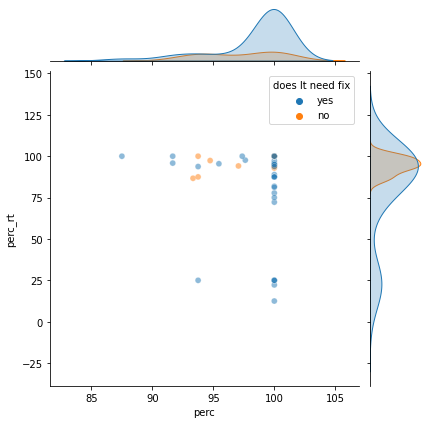

In [319]:
sns.jointplot(df, x='perc', y='perc_rt', hue='does It need fix', alpha=0.5)

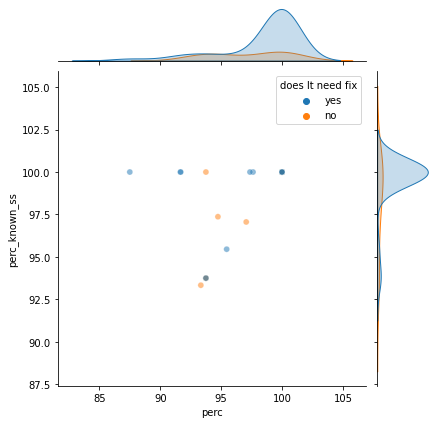

In [321]:
sns.jointplot(df, x='perc', y='perc_known_ss', hue='does It need fix', alpha=0.5)

In [327]:
df['new_minus_rt_perc_diff'] = df.perc-df.perc_rt

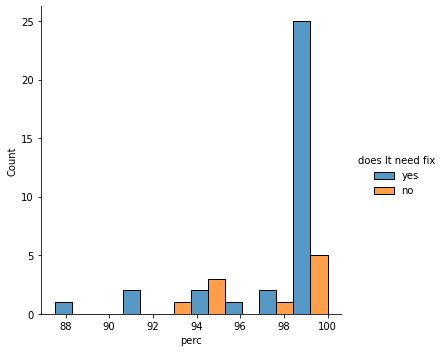

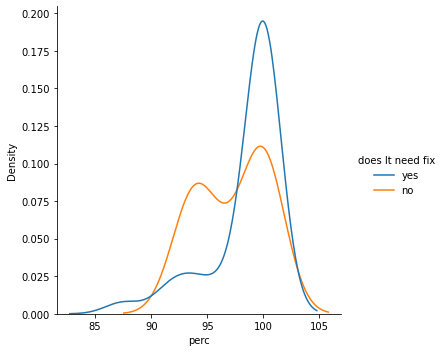

In [332]:
sns.displot(df, x='perc', hue='does It need fix', multiple='dodge')
sns.displot(df, x='perc', hue='does It need fix', kind='kde', common_norm = False)

In [ ]:
# sns.jointplot(df, x='perc', y='perc_known_ss', hue='does It need fix', alpha=0.5)

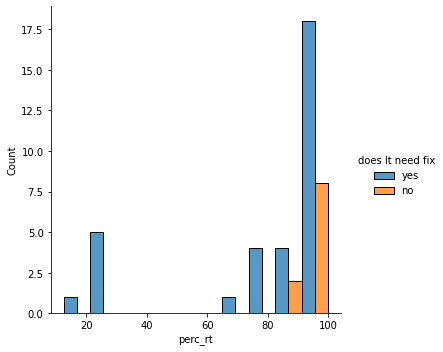

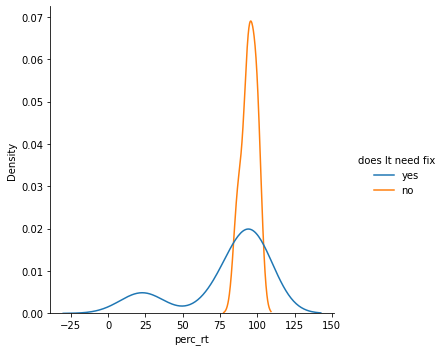

In [333]:
sns.displot(df, x='perc_rt', hue='does It need fix', multiple='dodge')
sns.displot(df, x='perc_rt', hue='does It need fix', kind='kde', common_norm = False)

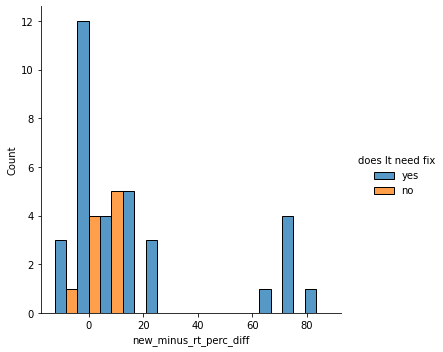

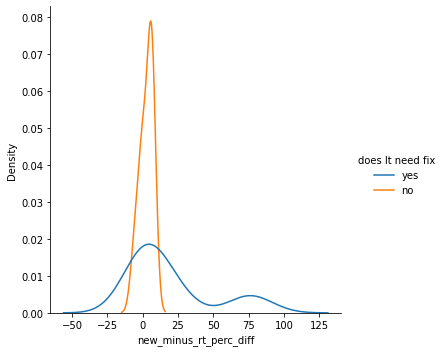

In [331]:
sns.displot(df, x='new_minus_rt_perc_diff', hue='does It need fix', multiple='dodge')
sns.displot(df, x='new_minus_rt_perc_diff', hue='does It need fix', kind='kde', common_norm = False)

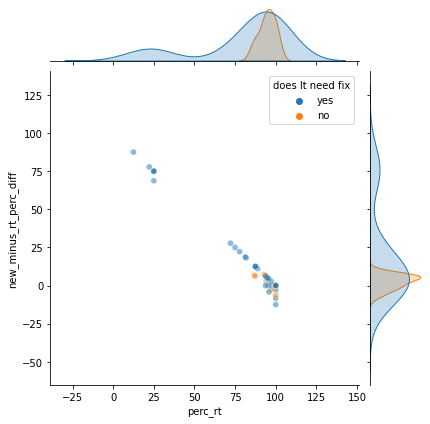

In [334]:
sns.jointplot(df, x='perc_rt', y='new_minus_rt_perc_diff', hue='does It need fix', alpha=0.5)

In [337]:
# sns.jointplot(df, x='perc_known_ss', y='new_minus_rt_perc_diff', hue='does It need fix', alpha=0.5)

In [338]:
df.loc[(df['does It need fix']=='yes')&(df.new_minus_rt_perc_diff>10)&(df.perc_rt>75)]

,Name,gid,n_total_ss,n_ss,n_rt_ss,perc,perc_rt,n_total_known_ss,perc_known_ss,Unnamed: 9,does It need fix,new_minus_rt_perc_diff
19,TALONT000553908,ENSG00000284431,22,22,18,100.0,81.818182,22,100.0,NaN,yes,18.181818
36,TALONT000643313,ENSG00000254413,18,18,14,100.0,77.777778,18,100.0,NaN,yes,22.222222
37,TALONT000466190,ENSG00000259529,18,18,16,100.0,88.888889,18,100.0,NaN,yes,11.111111
47,TALONT000560879,ENSG00000285589,16,16,14,100.0,87.500000,16,100.0,NaN,yes,12.500000
48,TALONT000643268,ENSG00000254413,16,16,13,100.0,81.250000,16,100.0,NaN,yes,18.750000
50,TALONT000643252,ENSG00000254413,16,16,14,100.0,87.500000,16,100.0,NaN,yes,12.500000
51,TALONT000560145,ENSG00000285589,16,16,14,100.0,87.500000,16,100.0,NaN,yes,12.500000


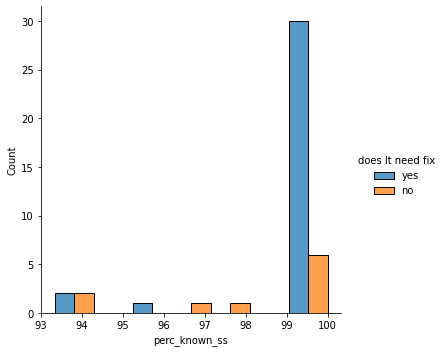

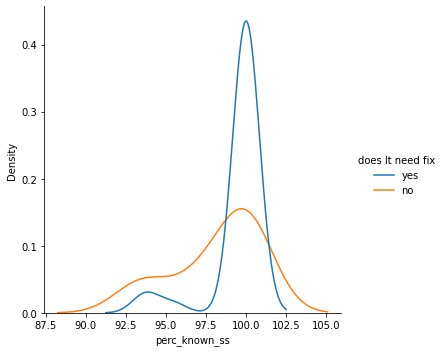

In [330]:
sns.displot(df, x='perc_known_ss', hue='does It need fix', multiple='dodge')
sns.displot(df, x='perc_known_ss', hue='does It need fix', kind='kde', common_norm = False)

## 231207 fix messed up gene assignments
* take all novel transcripts that belong to known genes
* that share at least one splice site with an annotated readthrough gene
* remove readthrough genes and count up the number of splice sites they share with other annotated genes

In [113]:
include_novel=False
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [142]:
# check when we hit annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
fusion_gids = rt_df.gid_stable.tolist()

In [114]:
print(len(df.index))
df = df.loc[(df.Name.isin(tids))].copy(deep=True)    
print(len(df.index))

191401
83566


In [132]:
known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [134]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [136]:
f_ss_ic_df.head()

# total # splice sss / transcript
temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
temp = temp[['Name', 'ss']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
temp.head()


,Name,n_total_ss
0,TALONT000206986,20
1,TALONT000206989,12
2,TALONT000207028,18
3,TALONT000207044,20
4,TALONT000207050,14


In [182]:
# splice sites / transcript that are from each gene
temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp2.drop_duplicates(inplace=True)
if include_novel == True:
    dropna = False
else:
    dropna = True
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)

# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_ss', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()

,Name,known,gene_id,n_ss,rank
78090,TALONT001292411,True,ENSG00000253729,169,1
79373,TALONT001491396,True,ENSG00000197102,140,1
39829,TALONT000703616,True,ENSG00000084636,138,1
39870,TALONT000704035,True,ENSG00000084636,138,1
39904,TALONT000704338,True,ENSG00000084636,136,1


In [183]:
# which transcripts have sss that overlap with annotated fusion regions
print(len(temp2.index))
temp2['sss_from_rt'] = temp2.gene_id.isin(fusion_gids)
print(len(temp2.loc[temp2.sss_from_rt==True].index))

# keep only the transcripts that have ssss that overlap with annotated fusion regions
tids_ss_fusion = temp2.loc[temp2.sss_from_rt==True, 'Name'].unique().tolist()
temp6 = temp2.loc[temp2.Name.isin(tids_ss_fusion)]
temp6.head()

85247
4560


,Name,known,gene_id,n_ss,rank,sss_from_rt
37645,TALONT000677056,True,ENSG00000095319,87,1,False
37647,TALONT000677064,True,ENSG00000095319,86,1,False
80203,TALONT001631422,True,ENSG00000095319,85,1,False
37714,TALONT000677650,True,ENSG00000095319,84,1,False
37669,TALONT000677260,True,ENSG00000095319,79,1,False


In [184]:
# get number of genes that have overlapping sss for each transcript
temp3 = temp6[['Name', 'gene_id']]
temp3 = temp3.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
temp3.columns = temp3.columns.map(''.join)
temp3.columns = ['Name', 'n_genes', 'gene_ids']
print(len(temp3.loc[temp3.n_genes>1].index))
print(len(temp3.index))
temp3.head()

4231
4336


,Name,n_genes,gene_ids
0,TALONT000212252,2,"ENSG00000067057,ENSG00000278419"
1,TALONT000212305,2,"ENSG00000067057,ENSG00000278419"
2,TALONT000212359,2,"ENSG00000067057,ENSG00000278419"
3,TALONT000212387,2,"ENSG00000067057,ENSG00000278419"
4,TALONT000212468,2,"ENSG00000067057,ENSG00000278419"


In [185]:
# get only the transcripts that overlap >1 gene
tids_mult_g = temp3.loc[temp3.n_genes>1, 'Name'].tolist()
temp4 = temp3.loc[temp3.Name.isin(tids_mult_g)]
print(len(temp4.index))
temp4.head()

4231


,Name,n_genes,gene_ids
0,TALONT000212252,2,"ENSG00000067057,ENSG00000278419"
1,TALONT000212305,2,"ENSG00000067057,ENSG00000278419"
2,TALONT000212359,2,"ENSG00000067057,ENSG00000278419"
3,TALONT000212387,2,"ENSG00000067057,ENSG00000278419"
4,TALONT000212468,2,"ENSG00000067057,ENSG00000278419"


In [191]:
# now, when removing the rt genes, how many genes do these overlap?
# get number of genes that have overlapping sss for each transcript from 
# our previous transcript set
print(len(temp2.index))
temp5 = temp2.loc[(temp2.sss_from_rt==False)&(temp2.Name.isin(tids_mult_g))]
print(len(temp5.index))

temp5 = temp5[['Name', 'gene_id']]
temp5 = temp5.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
temp5.columns = temp5.columns.map(''.join)
temp5.columns = ['Name', 'n_genes', 'gene_ids']
print(len(temp5.loc[temp5.n_genes==1].index))
print(len(temp5.index))
temp5.head()

85247
4500
3929
4210


,Name,n_genes,gene_ids
0,TALONT000212252,1,ENSG00000067057
1,TALONT000212305,1,ENSG00000067057
2,TALONT000212359,1,ENSG00000067057
3,TALONT000212387,1,ENSG00000067057
4,TALONT000212468,1,ENSG00000067057


In [192]:
temp7 = temp5.loc[temp5.n_genes==1]
temp7.to_csv('readthrough_genes_novel_transcripts_3.tsv', sep='\t', index=False)

In [164]:



# print(len(temp2.index))

# # drop entries from rt genes so we can count number of non-overlapping genes 
# # whose splice sites overlap the different transcripts
# temp2 = temp2.loc[temp2.sss_from_rt==False]
# print(len(temp2.index))


In [165]:
# temp2.head()

In [166]:
# # number of genes w/ intersecting sss / transcript
# temp3 = temp2[['Name', 'gene_id']]
# temp3 = temp3.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
# temp3.columns = temp3.columns.map(''.join)
# temp3.columns = ['Name', 'n_genes', 'gene_ids']
# print(len(temp3.loc[temp3.n_genes>1].index))
# temp3.head()

# # temp5 = temp.merge(temp2, on='Name')
# # temp5 = temp5.merge(temp3, on='Name')
# # temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100

In [167]:
# temp6 = temp3.loc[temp3.n_genes>1]
# temp6['gids_list'] = temp6.gene_ids.str.split(',')
# temp6 = temp6.explode('gids_list')
# temp6 = temp6[['gids_list']].drop_duplicates()
# temp6.to_csv('readthrough_genes_novel_transcripts_2.tsv', sep='\t', index=False)

## 231206 - correct other transcripts' gene assignments using exon matching?

In [88]:
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

novel_tids = talon_df.loc[talon_df.transcript_novelty!='Known', 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [89]:
talon_df.head()

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,...,h9_panc_progen_1_2,hepg2_2_1,hl60_m1_12hr_1_2,hl60_m2_72hr_1_2,k562_3_2,lower_lobe_of_right_lung_1_1,ovary_2_1,pgp1_endo_1_1,right_cardiac_atrium_3_1,gid
0,3,4,ENSG00000278267.1,ENST00000619216.1,MIR6859-1,MIR6859-1-201,1,68,Known,Known,...,0,0,1,0,0,0,0,0,0,ENSG00000278267
1,4,6,ENSG00000243485.5,ENST00000469289.1,MIR1302-2HG,MIR1302-2HG-201,2,535,Known,Known,...,0,0,0,0,0,0,0,0,0,ENSG00000243485
2,6,8,ENSG00000237613.2,ENST00000417324.1,FAM138A,FAM138A-201,3,1187,Known,Known,...,0,0,0,0,0,0,0,0,0,ENSG00000237613
3,6,9,ENSG00000237613.2,ENST00000461467.1,FAM138A,FAM138A-202,2,590,Known,Known,...,0,0,0,0,0,0,0,0,0,ENSG00000237613
4,10,19,ENSG00000238009.6,ENST00000453576.2,AL627309.1,AL627309.1-204,2,336,Known,Known,...,0,0,0,0,0,0,0,0,0,ENSG00000238009


In [91]:
print(len(df.index))
df = df.loc[df.Name.isin(novel_tids)].copy(deep=True)    
print(len(df.index))

known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

191401
94680


In [92]:
_, f_ss_ic_df = get_exon_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_exon_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [93]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [94]:
# total # exons / ic
temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
temp['exon'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+'_'+temp.End.astype(str)
temp = temp[['Name', 'exon']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'exon':'n_total_exons'}, axis=1, inplace=True)
temp.head()

,Name,n_total_exons
0,TALONT000206986,9
1,TALONT000206987,1
2,TALONT000206989,5
3,TALONT000207028,8
4,TALONT000207044,9


In [95]:
# unique exons / ic from each gene
temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
temp2['coords'] = temp2.Start.astype(str)+'_'+temp2.End.astype(str)
temp2.drop(['Start', 'End'], axis=1, inplace=True)
temp2.drop_duplicates(inplace=True)
if include_novel == True:
    dropna = False
else:
    dropna = True
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'coords': 'n_exons'}, axis=1, inplace=True)
temp2.head()

,Name,known,gene_id,n_exons
0,TALONT000206986,True,ENSG00000153404,9
1,TALONT000206989,True,SIRV6,5
2,TALONT000207028,True,ENSG00000227232,7
3,TALONT000207044,True,ENSG00000153404,9
4,TALONT000207050,True,SIRV6,6


In [96]:
# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_exons', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_exons', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()

,Name,known,gene_id,n_exons,rank
71954,TALONT001292411,True,ENSG00000253729,83,1
73155,TALONT001491396,True,ENSG00000197102,69,1
36760,TALONT000704035,True,ENSG00000084636,68,1
36723,TALONT000703616,True,ENSG00000084636,68,1
36792,TALONT000704338,True,ENSG00000084636,67,1


In [97]:
# number of genes w/ intersecting exons / ic
temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
temp3.head()

,Name,n_genes
0,TALONT000206986,1
1,TALONT000206989,1
2,TALONT000207028,1
3,TALONT000207044,1
4,TALONT000207050,1


In [98]:
temp5 = temp.merge(temp2, on='Name')
temp5 = temp5.merge(temp3, on='Name')
temp5['perc'] = (temp5['n_exons']/temp5['n_total_exons'])*100
temp5.head()

,Name,n_total_exons,known,gene_id,n_exons,rank,n_genes,perc
0,TALONT000206986,9,True,ENSG00000153404,9,1,1,100.0
1,TALONT000206989,5,True,SIRV6,5,1,1,100.0
2,TALONT000207028,8,True,ENSG00000227232,7,1,1,87.5
3,TALONT000207044,9,True,ENSG00000153404,9,1,1,100.0
4,TALONT000207050,6,True,SIRV6,6,1,1,100.0


In [109]:
print(len(temp5.loc[temp5.n_genes>1].gene_id.unique()))
temp5.loc[temp5.n_genes>1].head(50).tail(10)

1674


,Name,n_total_exons,known,gene_id,n_exons,rank,n_genes,perc
499,TALONT000215012,14,True,ENSG00000067057,14,1,2,100.000000
500,TALONT000215012,14,True,ENSG00000278419,1,2,2,7.142857
501,TALONT000215014,15,True,ENSG00000067057,15,1,2,100.000000
502,TALONT000215014,15,True,ENSG00000278419,1,2,2,6.666667
504,TALONT000215039,16,True,ENSG00000067057,16,1,2,100.000000
505,TALONT000215039,16,True,ENSG00000278419,1,2,2,6.250000
509,TALONT000215126,13,True,ENSG00000067057,13,1,2,100.000000
510,TALONT000215126,13,True,ENSG00000278419,1,2,2,7.692308
513,TALONT000215167,13,True,ENSG00000067057,13,1,2,100.000000
514,TALONT000215167,13,True,ENSG00000278419,1,2,2,7.692308


In [111]:
temp6 = temp5.loc[temp5.n_genes>1].copy(deep=True)
temp8 = temp6[['Name', 'gene_id']].groupby('gene_id').count().reset_index()
temp8.sort_values(by='Name', ascending=False, inplace=True)
temp8.head()

,gene_id,Name
1610,ENSG00000285238,61
839,ENSG00000214265,55
1524,ENSG00000280987,51
18,ENSG00000015479,50
207,ENSG00000111642,45


In [ ]:

# _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
# k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

# f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
#                           suffixes=('', '_known'))
# f_ss_ic_df['known'] = False
# f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

# # total # splice sss / ic
# temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
# temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
# temp = temp[['Name', 'ss']]
# temp = temp.groupby('Name').nunique().reset_index()
# temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
# temp.head()

# # splice sites / ic from each gene
# temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
# temp2.drop_duplicates(inplace=True)
# if include_novel == True:
#     dropna = False
# else:
#     dropna = True
# temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
# temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
# temp2.head()

# # number each gene as 1' 2' or 3'
# temp2 = temp2.sort_values(by='n_ss', ascending=False)
# temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
# temp2.head()

# # number of genes w/ intersecting sss / ic

# # check when we hit annotated fusion genes
# rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
# rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
# len(rt_df.index)
# rt_df.head()
# rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
# rt_df.head()
# temp3 = temp2.loc[temp2.gene_id.isin(rt_df.gid_stable.tolist())][['Name', 'gene_id']]
# # temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
# temp3 = temp3.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
# temp3.columns = temp3.columns.map(''.join)
# temp3.columns = ['Name', 'n_genes', 'gene_ids']
# # temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
# temp3.head()

# temp5 = temp.merge(temp2, on='Name')
# temp5 = temp5.merge(temp3, on='Name')
# temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100

## 231206 - try to correct other transcripts' gene assignments

In [7]:
include_novel=False

In [15]:
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [16]:
print(len(df.index))
df = df.loc[(df.Name.isin(tids))].copy(deep=True)    
print('was 94680')
print(len(df.index))

known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

# total # splice sss / ic
temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
temp = temp[['Name', 'ss']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
temp.head()

# splice sites / ic from each gene
temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp2.drop_duplicates(inplace=True)
if include_novel == True:
    dropna = False
else:
    dropna = True
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
temp2.head()

# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_ss', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()

# number of genes w/ intersecting sss / ic

# check when we hit annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
len(rt_df.index)
rt_df.head()
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df.head()
temp3 = temp2.loc[temp2.gene_id.isin(rt_df.gid_stable.tolist())][['Name', 'gene_id']]
# temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
temp3 = temp3.groupby('Name', dropna=dropna).agg({'gene_id': ['nunique', ','.join]}).reset_index()
temp3.columns = temp3.columns.map(''.join)
temp3.columns = ['Name', 'n_genes', 'gene_ids']
# temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
temp3.head()

temp5 = temp.merge(temp2, on='Name')
temp5 = temp5.merge(temp3, on='Name')
temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100

191401
was 94680
83566


In [17]:
print(len(temp3.index))
print(len(temp3.loc[temp3.n_genes>1].index))

4336
211


In [54]:
# temp3 = temp3.merge(talon_df[['annot_transcript_id', 'annot_gene_name']], left_on='Name', right_on='annot_transcript_id')

In [25]:
temp6 = temp3.loc[temp3.n_genes>1]
temp6['gids_list'] = temp6.gene_ids.str.split(',')
temp6 = temp6.explode('gids_list')
temp6 = temp6[['gids_list']].drop_duplicates()
temp6.to_csv('readthrough_genes_novel_transcripts.tsv', sep='\t')

In [22]:
temp6.loc[temp6.gids_list=='ENSG00000260899']

,gids_list
1772,ENSG00000260899


In [24]:
len(temp6)
temp6.head(10)

,gids_list
121,ENSG00000285845
121,ENSG00000285988
121,ENSG00000285743
153,ENSG00000284906
153,ENSG00000285077
153,ENSG00000187951
159,ENSG00000255639
159,ENSG00000272921
174,ENSG00000196204
174,ENSG00000272968


In [18]:
temp3.loc[temp3.gene_ids.str.contains('ENSG00000260899')]

,Name,n_genes,gene_ids
1772,TALONT000636852,2,"ENSG00000282034,ENSG00000260899"
1774,TALONT000636953,2,"ENSG00000260899,ENSG00000282034"
1778,TALONT000637494,1,ENSG00000260899
1779,TALONT000637495,1,ENSG00000260899
1780,TALONT000637497,1,ENSG00000260899
1781,TALONT000637508,1,ENSG00000260899
1782,TALONT000637511,1,ENSG00000260899
1784,TALONT000637622,1,ENSG00000260899
1789,TALONT000637792,1,ENSG00000260899
1792,TALONT000638355,1,ENSG00000260899


In [25]:
f_ss_ic_df.head()
len(f_ss_ic_df.index)

17025075

In [26]:
k_ss_ic_df.head()
len(k_ss_ic_df.index)

2084402

## pre- 231206

In [7]:
# getting rid of monoexonic novel transcripts
talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df.head()
talon_df.loc[talon_df.annot_gene_id == 'TALONG000189805']
monoex_int_tids = talon_df.loc[(talon_df.n_exons==1)&(talon_df.gene_novelty=='Intergenic'), 'annot_transcript_id']
len(monoex_int_tids)
talon_df.loc[talon_df.annot_gene_id == 'TALONG000189818']
gene_novs = ['Antisense', 'Intergenic', 'Fusion']
monoex_int_tids = talon_df.loc[(talon_df.n_exons==1)&(talon_df.gene_novelty.isin(gene_novs)), 'annot_transcript_id']
len(monoex_int_tids)

# talon_df.gene_novelty.unique()

9733

In [8]:
temp, df, fusion_df = get_fusion_ss_table(talon_filt_ab, talon_gtf, ref_ics, 'v40_cerberus', include_novel=False)

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [9]:
print(len(temp.Name.unique()))
temp.head()

556


,gene_id,Name,Chromosome,Strand,ss_type,Start,gene_id_known,Name_known,known
0,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_4,True
1,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_2,True
2,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_5,True
3,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_6,True
4,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_7,True


In [10]:
fusion_df.head()
print(len(fusion_df.Name.unique().tolist()))

# 0-gene ss intersection transcripts
novel_tids = list(set(fusion_df.Name.tolist())-set(temp.Name.tolist()))
print(len(novel_tids))

577
21


In [11]:
gtf_df = pr.read_gtf(talon_gtf, duplicate_attr=True, rename_attr=True)
gtf_df = gtf_df.df
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, 'gene_id')

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [12]:
ref_gtf_df = pr.read_gtf(ref_gtf, duplicate_attr=True, rename_attr=True)
ref_gtf_df = ref_gtf_df.df
ref_gtf_df['gid_stable'] = cerberus.get_stable_gid(ref_gtf_df, 'gene_id')

In [13]:
len(gtf_df.index)

1717647

In [14]:
df.head()
print(len(df.index))
print(len(df.Name.unique()))

731
524


In [15]:
temp.head()

,gene_id,Name,Chromosome,Strand,ss_type,Start,gene_id_known,Name_known,known
0,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_4,True
1,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_2,True
2,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_5,True
3,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_6,True
4,TALONG000073755,TALONT000303431,chr1,-,ss_5,2193638.0,ENSG00000162585,ENSG00000162585_7,True


In [16]:
# all ics w/ 2+ genes intersected -- fusion, keep their novelties
# add an entry to reflect that they're fusions between the genes that they intersected with
temp = df.loc[df.n_genes>=2]
temp = temp[['Name', 'gene_id']].groupby('Name').agg(','.join).reset_index()
temp.rename({'Name': 'transcript_id', 'gene_id': 'fusion_genes'}, axis=1, inplace=True)
gtf_df = gtf_df.merge(temp, how='left', on='transcript_id')

In [18]:
gtf_df.loc[gtf_df.fusion_genes.notnull()].head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,gid_stable,fusion_genes
82176,chr1,TALON,transcript,22636505,22648110,.,+,.,TALONG000114097,TALONG000114097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,TALONG000114097,"ENSG00000173372,ENSG00000159189"
82177,chr1,HAVANA,exon,22636505,22636702,.,+,.,TALONG000114097,TALONG000114097,...,CCDS226.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000114097,"ENSG00000173372,ENSG00000159189"
82178,chr1,HAVANA,exon,22637609,22637779,.,+,.,TALONG000114097,TALONG000114097,...,CCDS226.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000114097,"ENSG00000173372,ENSG00000159189"
82179,chr1,TALON,exon,22638832,22639161,.,+,.,TALONG000114097,TALONG000114097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000114097,"ENSG00000173372,ENSG00000159189"
82180,chr1,HAVANA,exon,22644010,22644204,.,+,.,TALONG000114097,TALONG000114097,...,CCDS227.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000114097,"ENSG00000173372,ENSG00000159189"


In [456]:
# gtf_df.loc[gtf_df.transcript_id=='TALONT000221106']

In [457]:
# gtf_df.loc[(gtf_df.gid_stable=='ENSG00000028310')&(gtf_df.Feature=='gene')]

In [458]:
print(len(gtf_df.index))

1717647


In [459]:
# all ics w/ just 1 gene intersected -- not fusion, update gene ids to intersected gene ids
temp = df.loc[df.n_genes == 1]
gene_cols = ['Source', 'gene_id', 'gene_name', 'gene_status', 'gene_type', 'talon_gene', 'havana_gene', 'level', 
             'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
talon_gene_cols = ['gene_status', 'talon_gene', 'antisense_gene', 'gene_antisense_to_IDs', 'intergenic_novel', 'fusion_novel']
for ind, entry in temp.iterrows():
    t = entry.Name
    inds = gtf_df.loc[gtf_df.transcript_id==t].index
    g = entry.gene_id
    dummy_gene_entry = gtf_df.loc[(gtf_df.gid_stable==g)&(gtf_df.Feature=='gene')]
    if len(dummy_gene_entry.index) == 0:
        # have to pull from reference gtf instead and add corresponding gene entry
        dummy_gene_entry = ref_gtf_df.loc[(ref_gtf_df.gid_stable==g)&(ref_gtf_df.Feature=='gene')]
        dummy_gene_entry[talon_gene_cols] = np.nan
        gtf_df = pd.concat([gtf_df, dummy_gene_entry], axis=0)
    assert len(dummy_gene_entry.index) == 1
    for c in gene_cols:
        gtf_df.loc[inds, c] = dummy_gene_entry[c].values[0]
    

In [460]:
print(len(gtf_df.index))

1717656


In [466]:
fusion_df.head()

,Chromosome,Strand,Name,gene_id,Coordinates,source
4824,chr1,-,TALONT000303431,TALONG000073755,2193638-2185513,lapa
5511,chr1,-,TALONT000607373,TALONG000117931,23913245-23865625-23865490-23863271-23863133-2...,lapa
5722,chr1,-,TALONT000694012,TALONG000129656,31372941-31369557-31369384-31367494-31367392-3...,lapa
5872,chr1,-,TALONT000740223,TALONG000135531,34885477-34885063-34884977-34869089-34868604-3...,lapa
5874,chr1,-,TALONT000740244,TALONG000135531,34868604-34867627-34867535-34867191-34867047-3...,lapa


In [467]:
# all ics w/o any genes intersected -- change to intergenic genes? (need to double check)
temp2 = fusion_df.loc[(fusion_df.Name.isin(novel_tids))&(fusion_df.Coordinates!='-')]
assert len(temp2) == 0
novel_gids = fusion_df.loc[(fusion_df.Name.isin(novel_tids)), 'gene_id']
len(novel_gids)
# jk delete these cause they're all genomic

21

In [463]:
gtf_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,gid_stable,fusion_genes
0,ERCC-00002,spikein,gene,0,1061,.,+,.,gSpikein_ERCC-00002,TALON-58809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gSpikein_ERCC-00002,NaN
1,ERCC-00002,spikein,transcript,0,1061,.,+,.,gSpikein_ERCC-00002,TALON_gene-58809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gSpikein_ERCC-00002,NaN
2,ERCC-00002,spikein,exon,0,1061,.,+,.,gSpikein_ERCC-00002,TALON_gene-58809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gSpikein_ERCC-00002,NaN
3,ERCC-00002,TALON,gene,0,1061,.,-,.,TALONG000193759,TALONG000193759,...,NaN,TRUE,58809,NaN,NaN,NaN,NaN,NaN,TALONG000193759,NaN
4,ERCC-00002,TALON,transcript,0,1061,.,-,.,TALONG000193759,TALONG000193759,...,NaN,NaN,NaN,TRUE,NaN,NaN,NaN,NaN,TALONG000193759,NaN


In [468]:
print(len(gtf_df.index))
gtf_df = gtf_df.loc[~gtf_df.gid_stable.isin(novel_gids)]
print(len(gtf_df.index))
                                            

1717656
1717352


In [469]:
gtf_df.drop('gid_stable', axis=1, inplace=True)

In [484]:
df.loc[df.n_genes == 1] # ENSG00000028310
gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000028310')]
530888 - 498827

32061

In [481]:
print(gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000028310')].Start.max())
print(gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000028310')].End.max())
gtf_df.loc[(gtf_df.gene_id.str.contains('ENSG00000028310'))&(gtf_df.Start==892605)]

892605
892824


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
498839,chr5,HAVANA,exon,892605,892800,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498856,chr5,HAVANA,exon,892605,892800,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498957,chr5,HAVANA,exon,892605,892824,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000419765.1,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498982,chr5,HAVANA,exon,892605,892800,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530873,chr5,HAVANA,exon,892605,892800,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [497]:
gtf_df.loc[gtf_df.Start>gtf_df.End].head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes


In [482]:
# oops, need to first sort gtf and update the ends of genes
gtf_df = cerberus.sort_gtf(gtf_df)

In [486]:
887197-887024
gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000028310')]


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
887024,chr5,HAVANA,gene,863740,892800,.,-,.,ENSG00000028310.17,BRD9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887025,chr5,HAVANA,transcript,864272,892824,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000419765.1,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887026,chr5,HAVANA,exon,892605,892824,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000419765.1,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887027,chr5,HAVANA,exon,891639,891854,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887028,chr5,HAVANA,exon,891154,891287,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887193,chr5,HAVANA,exon,876100,876212,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887194,chr5,HAVANA,exon,871525,871564,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887195,chr5,HAVANA,exon,870472,870575,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887196,chr5,HAVANA,exon,865413,865581,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [501]:
df.loc[df.n_genes == 1] #ENSG00000147853
print(gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000147853'), 'Start'].min())
print(gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000147853'), 'End'].max())
gtf_df.loc[gtf_df.gene_id.str.contains('ENSG00000147853')]
print(4709558 < 4742043)
print(4742043 < 4741227)


4709558
4742043
True
False


In [500]:
df.loc[df.gene_id == 'ENSG00000147853']
gtf_df.loc[gtf_df.transcript_id == 'TALONT000215329']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
1341161,chr9,HAVANA,transcript,4711154,4718537,.,-,.,ENSG00000147853.16,AK3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341162,chr9,HAVANA,exon,4718418,4718537,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341163,chr9,HAVANA,exon,4711154,4713096,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gtf_temp.loc[gtf_temp.gene_id.str.contains('ENSG00000147853')]


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
1341080,chr9,HAVANA,gene,4709558,4741227,.,-,.,ENSG00000147853.16,AK3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341081,chr9,HAVANA,transcript,4712044,4742043,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000352948.2,CCDS56561.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341082,chr9,HAVANA,exon,4741971,4742043,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000352948.2,CCDS56561.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341083,chr9,HAVANA,exon,4722505,4722625,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341084,chr9,HAVANA,exon,4719134,4719307,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341085,chr9,HAVANA,exon,4718418,4718537,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341086,chr9,HAVANA,exon,4712044,4713096,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000352948.2,CCDS56561.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341087,chr9,HAVANA,transcript,4711154,4741318,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341088,chr9,HAVANA,exon,4740936,4741318,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341089,chr9,HAVANA,exon,4722505,4722625,.,-,.,ENSG00000147853.16,AK3,...,ENSP00000371230.3,CCDS6455.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [512]:
tids = df.loc[df.n_genes==1].Name.tolist()
temp6 = gtf_df.loc[(gtf_df.Strand=='+')&(gtf_df.transcript_id.isin(tids))&(gtf_df.Feature=='transcript')]
temp6 = temp6[['gene_id', 'Start', 'End']]
temp6.rename({'Start': 'n_t_start', 'End': 'n_t_end'}, axis=1, inplace=True)
temp6.head()
gtf_df = gtf_df.merge(temp6, how='left', on='gene_id')
gtf_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes,n_t_start,n_t_end
0,chrX,HAVANA,gene,100584801,100599885,.,+,.,ENSG00000000005.5,TNMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chrX,HAVANA,transcript,100584801,100599885,.,+,.,ENSG00000000005.5,TNMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chrX,HAVANA,exon,100584801,100585066,.,+,.,ENSG00000000005.5,TNMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chrX,HAVANA,exon,100585230,100585362,.,+,.,ENSG00000000005.5,TNMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chrX,HAVANA,exon,100593894,100594035,.,+,.,ENSG00000000005.5,TNMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [519]:
# which coords SHOULD be getting updated? 
temp7 = gtf_df.loc[gtf_df.n_t_start.notnull()].copy(deep=True)
# tsss need updating
temp7 = temp7.loc[(temp7.Start > temp7.n_t_start)&(temp7.Feature=='gene')][['Start', 'End', 'gene_id', 'n_t_start', 'n_t_end']]
temp7.head()

,Start,End,gene_id,n_t_start,n_t_end
95258,173714940,173785513,ENSG00000076321.10,173637712.0,173786702.0
95259,173714940,173785513,ENSG00000076321.10,173637712.0,173786702.0
140718,105694543,105775814,ENSG00000095209.11,105656100.0,105775814.0
196333,2249310,2252073,ENSG00000104899.7,2248488.0,2252073.0
292111,152697894,152724501,ENSG00000120279.6,152683269.0,152724567.0


In [530]:
# gtf_temp.loc[gtf_temp.gene_id == 'ENSG00000076321.10']
gtf_temp.loc[gtf_temp.gene_id == 'ENSG00000095209.11']


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes,n_t_start,n_t_end
140718,chr9,HAVANA,gene,105656100,105776612,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140719,chr9,HAVANA,transcript,105694543,105776612,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140720,chr9,HAVANA,exon,105694543,105694772,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140721,chr9,HAVANA,exon,105705596,105705753,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140722,chr9,HAVANA,exon,105721536,105721721,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140805,chr9,TALON,transcript,105721686,105775814,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140806,chr9,HAVANA,exon,105721686,105721721,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140807,chr9,HAVANA,exon,105722533,105722621,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0
140808,chr9,HAVANA,exon,105748072,105748190,.,+,.,ENSG00000095209.11,TMEM38B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105656100.0,105775814.0


In [526]:
# which coords SHOULD be getting updated? 
temp7 = gtf_df.loc[gtf_df.n_t_start.notnull()].copy(deep=True)
# tess need updating
temp7 = temp7.loc[(temp7.End < temp7.n_t_end)&(temp7.Feature=='gene')][['Start', 'End', 'gene_id', 'n_t_start', 'n_t_end']]
temp7.head()
# temp7.loc[temp7.gene_id=='ENSG00000012171.19'] 
temp7.loc[temp7.gene_id=='ENSG00000014257.15']

,Start,End,gene_id,n_t_start,n_t_end
20754,132317366,132332626,ENSG00000014257.15,132317368.0,132392721.0


In [524]:
# gtf_df.loc[(gtf_df.End==50277179)&(gtf_df.Chromosome=='chr3')].head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes,n_t_start,n_t_end
16562,chr3,HAVANA,transcript,50269005,50277179,.,+,.,ENSG00000012171.19,SEMA3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50267607.0,50277165.0
16563,chr3,HAVANA,transcript,50269005,50277179,.,+,.,ENSG00000012171.19,SEMA3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50269005.0,50277161.0
16564,chr3,HAVANA,transcript,50269005,50277179,.,+,.,ENSG00000012171.19,SEMA3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50273151.0,50277139.0
16613,chr3,HAVANA,exon,50276301,50277179,.,+,.,ENSG00000012171.19,SEMA3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50267607.0,50277165.0
16614,chr3,HAVANA,exon,50276301,50277179,.,+,.,ENSG00000012171.19,SEMA3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50269005.0,50277161.0


In [527]:
# gtf_temp.loc[gtf_temp.gene_id == 'ENSG00000012171.19']
gtf_temp.loc[gtf_temp.gene_id == 'ENSG00000014257.15']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
19814,chr3,HAVANA,gene,132317366,132392721,.,+,.,ENSG00000014257.15,ACPP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19815,chr3,HAVANA,transcript,132317366,132358752,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19816,chr3,HAVANA,exon,132317366,132317576,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19817,chr3,HAVANA,exon,132328266,132328362,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19818,chr3,HAVANA,exon,132331646,132331733,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19882,chr3,HAVANA,exon,132344926,132345059,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19883,chr3,HAVANA,exon,132349919,132350002,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19884,chr3,HAVANA,exon,132352719,132352823,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000337471.5,CCDS3073.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19885,chr3,HAVANA,exon,132356685,132356855,.,+,.,ENSG00000014257.15,ACPP,...,ENSP00000323036.8,CCDS46916.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [528]:
# mainly ripped out of cerberus code
gtf_temp = gtf_df.copy(deep=True)
for mode in ['tss', 'tes']:
        fwd, rev = cerberus.get_stranded_gtf_dfs(gtf_temp)
        df = pd.DataFrame()
        for strand, temp in zip(['+', '-'], [fwd, rev]):

            # fix gene boundaries
            temp = cerberus.update_gene_ends(temp, mode, strand)
            df = pd.concat([df, temp], ignore_index=True)

        gtf_temp = df.copy(deep=True)

In [489]:
gtf_temp.loc[gtf_temp.gene_id.str.contains('ENSG00000028310')]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,protein_id,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,fusion_genes
886967,chr5,HAVANA,gene,863740,892800,.,-,.,ENSG00000028310.17,BRD9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886968,chr5,HAVANA,transcript,864272,892824,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000419765.1,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886969,chr5,HAVANA,exon,892605,892824,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000419765.1,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886970,chr5,HAVANA,exon,891639,891854,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000420080.1,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886971,chr5,HAVANA,exon,891154,891287,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887136,chr5,HAVANA,exon,876100,876212,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887137,chr5,HAVANA,exon,871525,871564,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887138,chr5,HAVANA,exon,870472,870575,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887139,chr5,HAVANA,exon,865413,865581,.,-,.,ENSG00000028310.17,BRD9,...,ENSP00000417431.2,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [531]:
pr.PyRanges(gtf_df).to_gtf('fusion_fix.gtf')

In [434]:
# len(temp.index)
# temp.iloc[69]

In [435]:
# gtf_df.loc[(gtf_df.gid_stable=='ENSG00000227191')&(gtf_df.Feature=='gene')]
# gtf_df.loc[(gtf_df.gene_name=='TRGC2')&(gtf_df.Feature=='gene')]

In [436]:
# gtf_df.loc[gtf_df.transcript_id=='TALONT000214728']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,...,ccdsid,antisense_gene,gene_antisense_to_IDs,antisense_transcript,intergenic_novel,intergenic_transcript,fusion_novel,fusion_transcript,gid_stable,fusion_genes
530872,chr5,HAVANA,transcript,863740,892800,.,-,.,ENSG00000028310.17,BRD9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530873,chr5,HAVANA,exon,892605,892800,.,-,.,ENSG00000028310.17,BRD9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530874,chr5,HAVANA,exon,891639,891854,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530875,chr5,HAVANA,exon,891154,891287,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530876,chr5,HAVANA,exon,889586,889647,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530877,chr5,HAVANA,exon,889020,889165,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34127.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530878,chr5,HAVANA,exon,887360,887471,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530879,chr5,HAVANA,exon,886591,886704,.,-,.,ENSG00000028310.17,BRD9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530880,chr5,HAVANA,exon,883937,884070,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN
530881,chr5,HAVANA,exon,881106,881182,.,-,.,ENSG00000028310.17,BRD9,...,CCDS34128.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TALONG000059968,NaN


,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc
0,TALONG000059968_1,30,True,ENSG00000028310,29,1,1,96.666667
1,TALONG000060033_1,2,True,ENSG00000147853,2,1,1,100.000000
2,TALONG000060864_1,28,True,ENSG00000167699,15,1,2,53.571429
3,TALONG000060864_1,28,True,ENSG00000167693,13,2,2,46.428571
4,TALONG000061086_1,10,True,ENSG00000146540,9,1,1,90.000000


In [350]:
# spot check some fusion ICs w/ 2 genes
df.loc[df.n_genes == 0].head(10).tail(10)

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc


In [303]:
ss_2_genes = df.loc[df.n_genes>=2, 'gene_id'].unique().tolist()

In [320]:
# spot check some fusion ICs w/ 2 genes
df.loc[df.n_genes == 2].head(10).tail(10)

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc
2,TALONG000060864_1,28,True,ENSG00000167699,15,1,2,53.571429
3,TALONG000060864_1,28,True,ENSG00000167693,13,2,2,46.428571
8,TALONG000062014_1,30,True,ENSG00000185615,20,1,2,66.666667
9,TALONG000062014_1,30,True,ENSG00000242173,10,2,2,33.333333
10,TALONG000062014_2,28,True,ENSG00000185615,18,1,2,64.285714
11,TALONG000062014_2,28,True,ENSG00000242173,10,2,2,35.714286
12,TALONG000062458_1,10,True,ENSG00000103202,7,1,2,70.000000
13,TALONG000062458_1,10,True,ENSG00000236829,3,2,2,30.000000
19,TALONG000070061_1,14,True,ENSG00000154080,7,1,2,50.000000
20,TALONG000070061_1,14,True,ENSG00000171885,7,2,2,50.000000


In [309]:
# df.loc[df.Name=='TALONG000070853_1']

In [310]:
# df.loc[df.gene_id=='ENSG00000136143']

In [321]:
# spot check some fusion ICs w/ 1 genes
df.loc[df.n_genes == 1].head(10).tail(10)

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc
0,TALONG000059968_1,30,True,ENSG00000028310,29,1,1,96.666667
1,TALONG000060033_1,2,True,ENSG00000147853,2,1,1,100.000000
4,TALONG000061086_1,10,True,ENSG00000146540,9,1,1,90.000000
5,TALONG000061086_2,10,True,ENSG00000146540,8,1,1,80.000000
6,TALONG000061194_1,8,True,ENSG00000188002,8,1,1,100.000000
7,TALONG000061194_2,6,True,ENSG00000188002,6,1,1,100.000000
14,TALONG000062815_1,8,True,ENSG00000169100,8,1,1,100.000000
15,TALONG000063684_1,8,True,ENSG00000123933,8,1,1,100.000000
16,TALONG000063684_2,12,True,ENSG00000123933,10,1,1,83.333333
17,TALONG000066573_1,24,True,ENSG00000111319,24,1,1,100.000000


## try with sjs

In [289]:
temp, df2 = get_fusion_sj_table(talon_filt_ab, ics, 'v40_cerberus', include_novel=False)

In [290]:
sj_2_genes = df2.loc[df2.n_genes>=2, 'gene_id'].unique().tolist()

In [292]:
# what is overlap
print(len(sj_2_genes))
print(len(ss_2_genes))
ss_2_genes = set(ss_2_genes)
sj_2_genes = set(sj_2_genes)
print(len(ss_2_genes&sj_2_genes))
print(len(ss_2_genes-sj_2_genes))

76
112
76
36


In [253]:
# temp.loc[temp.Name=='TALONG000084534_1']

In [254]:
# spot check some fusion ICs w/ 2 genes
df.loc[df.n_genes == 2].head(30).tail(10)

,Name,n_total_sj,known,gene_id,n_sj,rank,n_genes,perc
78,TALONG000092062_1,8,True,ENSG00000093183,5,1,2,62.500000
79,TALONG000092062_1,8,True,ENSG00000230084,2,2,2,25.000000
81,TALONG000093027_1,12,True,ENSG00000131730,8,1,2,66.666667
82,TALONG000093027_1,12,True,ENSG00000131732,3,2,2,25.000000
95,TALONG000098911_1,6,True,ENSG00000213551,4,1,2,66.666667
96,TALONG000098911_1,6,True,ENSG00000182180,2,2,2,33.333333
97,TALONG000099063_1,17,True,ENSG00000136271,13,1,2,76.470588
98,TALONG000099063_1,17,True,ENSG00000158604,3,2,2,17.647059
104,TALONG000105193_3,12,True,ENSG00000174444,9,1,2,75.000000
105,TALONG000105193_3,12,True,ENSG00000174446,2,2,2,16.666667


In [268]:
# what about ICs w/ just one gene
df.loc[df.n_genes == 1].head(20).tail(10)

,Name,n_total_sj,known,gene_id,n_sj,rank,n_genes,perc
18,TALONG000070853_2,6,True,ENSG00000099622,5,1,1,83.333333
19,TALONG000070853_3,6,True,ENSG00000099622,6,1,1,100.000000
20,TALONG000070853_4,6,True,ENSG00000099622,5,1,1,83.333333
21,TALONG000070853_5,1,True,ENSG00000099622,1,1,1,100.000000
22,TALONG000071041_1,10,True,ENSG00000136143,9,1,1,90.000000
23,TALONG000071041_2,9,True,ENSG00000136143,8,1,1,88.888889
24,TALONG000071041_3,11,True,ENSG00000136143,10,1,1,90.909091
25,TALONG000072297_1,2,True,ENSG00000160207,1,1,1,50.000000
26,TALONG000075931_1,12,True,ENSG00000221829,12,1,1,100.000000
27,TALONG000075931_2,14,True,ENSG00000221829,13,1,1,92.857143


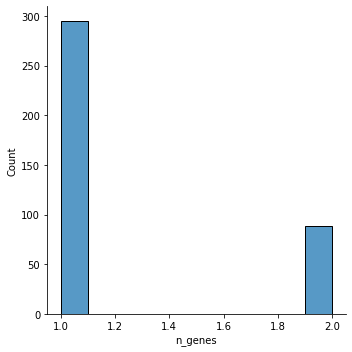

In [236]:
sns.displot(df, kind='hist', x='n_genes')

In [239]:
df = get_fusion_sj_table(talon_filt_ab, ics, 'v40_cerberus', include_novel=True)

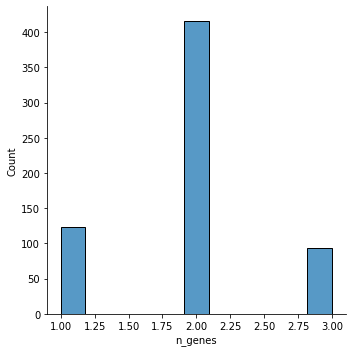

In [238]:
sns.displot(df, kind='hist', x='n_genes')

In [204]:
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

,gid_stable,gname
0,ENSG00000000460,C1orf112
1,ENSG00000000971,CFH
2,ENSG00000001461,NIPAL3
3,ENSG00000004487,KDM1A
4,ENSG00000007933,FMO3


In [205]:
talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

In [206]:
fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()

In [207]:
df = pd.read_csv(ics, sep='\t')
df['gene_id'] = df.Name.str.split('_', expand=True)[0]
df['source'] = 'lapa'

In [208]:
fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)

In [209]:
known_df = df.loc[df.gene_id.isin(known_gids)]

In [221]:
_, f_sj_ic_df = get_sj_from_ic(fusion_df, ['lapa'])
f_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [222]:
_, k_sj_ic_df = get_sj_from_ic(known_df, ['lapa'])
k_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [223]:
f_sj_ic_df = f_sj_ic_df.merge(k_sj_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                              suffixes=('', '_known'))
f_sj_ic_df['known'] = False
f_sj_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [224]:
f_sj_ic_df.head()

,Chromosome,Strand,gene_id,Name,Start,End,gene_id_known,Name_known,known
0,chr1,+,TALONG000169854,TALONG000169854_1,103525823,103526066,ENSG00000185946,ENSG00000185946_1,True
1,chr1,+,TALONG000169854,TALONG000169854_1,103526262,103527694,ENSG00000185946,ENSG00000185946_1,True
2,chr1,+,TALONG000169854,TALONG000169854_1,103526262,103527694,ENSG00000185946,ENSG00000185946_2,True
3,chr1,+,TALONG000169854,TALONG000169854_1,103526262,103527694,ENSG00000185946,ENSG00000185946_3,True
4,chr1,+,TALONG000169854,TALONG000169854_1,103526262,103527694,ENSG00000185946,ENSG00000185946_4,True


In [225]:
# total # splice sjs / ic
temp = f_sj_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
temp['sj'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+temp.End.astype(str)
temp = temp[['Name', 'sj']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'sj':'n_total_sj'}, axis=1, inplace=True)
temp.head()

,Name,n_total_sj
0,TALONG000059968_1,15
1,TALONG000061086_1,5
2,TALONG000061086_2,5
3,TALONG000061194_1,4
4,TALONG000061194_2,3


In [227]:
# splice junctions / ic from each gene
temp2 = f_sj_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
temp2.drop_duplicates(inplace=True)
temp2.drop('End', axis=1, inplace=True)
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=False).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_sj'}, axis=1, inplace=True)
temp2.head()

# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_sj', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_sj', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()

,Name,known,gene_id,n_sj,rank
84,TALONG000084529_1,True,ENSG00000103995,25,1
311,TALONG000136058_1,True,ENSG00000197043,24,1
479,TALONG000158719_1,True,ENSG00000162434,22,1
691,TALONG000264779_1,True,ENSG00000165801,22,1
629,TALONG000189031_3,True,ENSG00000198952,21,1


In [228]:
# number of genes w/ intersecting sjs / ic
temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=False).nunique(dropna=False).reset_index()
temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
temp3.head()

[2 1 3]


,Name,n_genes
0,TALONG000059968_1,2
1,TALONG000061086_1,2
2,TALONG000061086_2,2
3,TALONG000061194_1,1
4,TALONG000061194_2,2


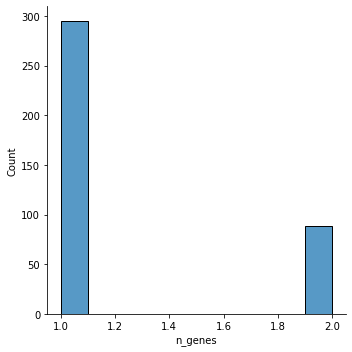

## 231120

In [57]:
_, f_ss_ic_df = get_ss_from_ic(fusion_df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [58]:
_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [59]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                              suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [60]:
f_ss_ic_df.head()

,gene_id,Name,Chromosome,Strand,ss_type,Start,gene_id_known,Name_known,known
0,TALONG000169854,TALONG000169854_1,chr1,+,ss_5,103525823.0,ENSG00000185946,ENSG00000185946_1,True
1,TALONG000169854,TALONG000169854_1,chr1,+,ss_5,103526262.0,ENSG00000185946,ENSG00000185946_1,True
2,TALONG000169854,TALONG000169854_1,chr1,+,ss_5,103526262.0,ENSG00000185946,ENSG00000185946_2,True
3,TALONG000169854,TALONG000169854_1,chr1,+,ss_5,103526262.0,ENSG00000185946,ENSG00000185946_3,True
4,TALONG000169854,TALONG000169854_1,chr1,+,ss_5,103526262.0,ENSG00000185946,ENSG00000185946_4,True


In [199]:
# for each ic, what % of the sss are supported by known gene sss?
temp = f_ss_ic_df[['Name', 'known', 'Start']].copy(deep=True)
temp.groupby(['Name', 'known']).count().reset_index()


,Name,known,Start
0,TALONG000059968_1,False,1
1,TALONG000059968_1,True,210
2,TALONG000061086_1,False,1
3,TALONG000061086_1,True,81
4,TALONG000061086_2,False,1
...,...,...,...
540,TALONG000436164_1,True,22
541,TALONG000443992_1,False,2
542,TALONG000450678_1,False,4
543,TALONG000504098_1,False,1


In [200]:
# for each ic, what % of the sss are supported by known gene sss, and are there more than one gene?
temp = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp = temp.groupby(['Name', 'known', 'gene_id_known'], dropna=False).count().reset_index()

# howmany genes 
temp2 = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()

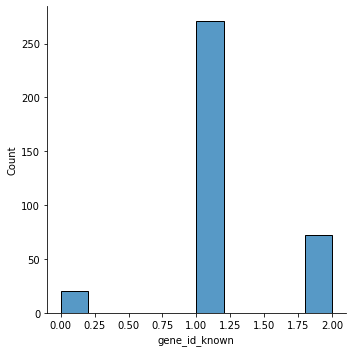

In [201]:
temp2
sns.displot(temp2, kind='hist', x='gene_id_known')

In [202]:
temp2.head()

,Name,gene_id_known
0,TALONG000059968_1,1
1,TALONG000061086_1,1
2,TALONG000061086_2,1
3,TALONG000061194_1,1
4,TALONG000061194_2,1


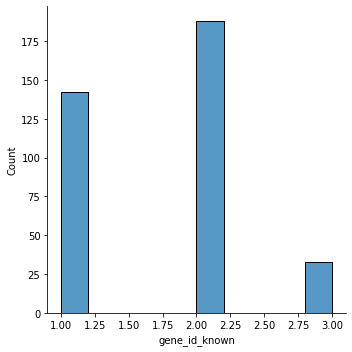

In [79]:
# for each ic, what % of the sss are supported by known gene sss, and are there more than one gene?
temp = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp = temp.groupby(['Name', 'known', 'gene_id_known'], dropna=False).count().reset_index()

# howmany genes ( including no genes)
temp2 = temp[['Name', 'gene_id_known']].groupby('Name', dropna=False).nunique(dropna=False).reset_index()

temp2
sns.displot(temp2, kind='hist', x='gene_id_known')

In [77]:
temp = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp = temp.groupby(['Name', 'known', 'gene_id_known'], dropna=False).count().reset_index()
temp.head()

,Name,known,gene_id_known,Start
0,TALONG000059968_1,False,NaN,1
1,TALONG000059968_1,True,ENSG00000028310,210
2,TALONG000061086_1,False,NaN,1
3,TALONG000061086_1,True,ENSG00000146540,81
4,TALONG000061086_2,False,NaN,1


In [78]:
temp2 = temp[['Name', 'gene_id_known']].groupby('Name', dropna=False).nunique(dropna=False).reset_index()
temp2.loc[temp2.Name=='TALONG000059968_1']

,Name,gene_id_known
0,TALONG000059968_1,1


In [114]:
# total # splice sites / ic
temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
temp = temp[['Name', 'ss']]
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
temp.head()

,Name,n_total_ss
0,TALONG000059968_1,30
1,TALONG000061086_1,10
2,TALONG000061086_2,10
3,TALONG000061194_1,8
4,TALONG000061194_2,6


In [115]:
# splice sites / ic from each gene
temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
temp2.drop_duplicates(inplace=True)
temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=False).count().reset_index()
temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
temp2.head()

# number each gene as 1' 2' or 3'
temp2 = temp2.sort_values(by='n_ss', ascending=False)
temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
temp2.head()
temp2.loc[temp2.Name=='TALONG000077252_1']

,Name,known,gene_id,n_ss,rank
45,TALONG000077252_1,True,ENSG00000147041,31,1
46,TALONG000077252_1,True,ENSG00000259977,2,2
44,TALONG000077252_1,False,NaN,1,3


In [116]:
# number of genes w/ intersecting sss / ic
temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=False).nunique(dropna=False).reset_index()
temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
print(temp3.n_genes.unique())
temp3.head()

[2 1 3]


,Name,n_genes
0,TALONG000059968_1,2
1,TALONG000061086_1,2
2,TALONG000061086_2,2
3,TALONG000061194_1,1
4,TALONG000061194_2,1


       Name
known      
False    20
True    122


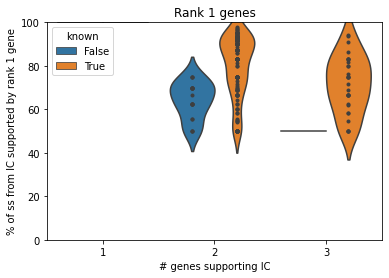

Empty DataFrame
Columns: [Name]
Index: []


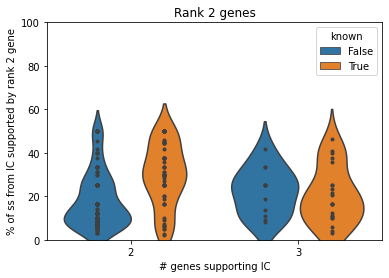

Empty DataFrame
Columns: [Name]
Index: []


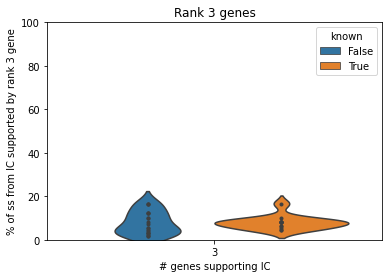

<Figure size 432x288 with 0 Axes>

In [154]:
for i in temp2['rank'].unique():
    temp4 = temp2.loc[temp2['rank']==i].copy(deep=True)

    temp5 = temp.merge(temp4, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    
    temp5['perc_for_gene'] = (temp5['n_ss']/temp5['n_total_ss'])*100
    
    print(temp5.loc[temp5.n_genes==1][['Name', 'known']].groupby('known').count())
    
    ax = sns.violinplot(temp5, x='n_genes', y='perc_for_gene', hue='known', inner='point')
    ylabel = f'% of ss from IC supported by rank {i} gene'
    title = f'Rank {i} genes'
    ax.set(xlabel='# genes supporting IC', ylabel=ylabel, title=title, ylim=(0,100))
    plt.show()
    plt.clf()


In [193]:
temp5 = temp.merge(temp2, on='Name')
temp5 = temp5.merge(temp3, on='Name')
temp5['perc_for_gene'] = (temp5['n_ss']/temp5['n_total_ss'])*100
temp5 = temp5.merge(gtf_df, how='left', left_on='gene_id', right_on='gid_stable')
temp5.head()
print(temp5['rank'].unique())
temp5.loc[temp5.gname.fillna('').str.contains('AQP')]

[1 2 3]


,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
20,TALONG000070061_1,14,True,ENSG00000171885,7,2,2,50.0,ENSG00000171885,AQP4
83,TALONG000084652_1,6,True,ENSG00000186466,3,2,2,50.0,ENSG00000186466,AQP7P1
86,TALONG000084652_2,6,True,ENSG00000186466,3,2,2,50.0,ENSG00000186466,AQP7P1


In [ ]:
temp5.loc[temp5.n_genes]

In [151]:
temp5.loc[temp5['rank']==1].head()
temp5.tail()

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene
612,TALONG000436164_1,22,True,ENSG00000229271,1,3,3,4.545455
613,TALONG000443992_1,2,False,NaN,2,1,1,100.000000
614,TALONG000450678_1,4,False,NaN,4,1,1,100.000000
615,TALONG000504098_1,14,True,ENSG00000136160,13,1,2,92.857143
616,TALONG000504098_1,14,False,NaN,1,2,2,7.142857


In [152]:
temp5.loc[temp5['rank']==1, 'perc_for_gene'].min()

50.0

In [184]:
temp5.loc[(temp5['rank']==1)&(temp5.perc_for_gene==50)]

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
21,TALONG000070061_1,14,True,ENSG00000154080,7,1,2,50.0,ENSG00000154080,CHST9
84,TALONG000084652_1,6,False,NaN,3,1,2,50.0,NaN,NaN
85,TALONG000084652_2,6,False,NaN,3,1,2,50.0,NaN,NaN
243,TALONG000132900_1,8,True,ENSG00000118640,4,1,3,50.0,ENSG00000118640,VAMP8
249,TALONG000134134_1,6,True,ENSG00000131873,3,1,2,50.0,ENSG00000131873,CHSY1
275,TALONG000136431_14,10,False,NaN,5,1,3,50.0,NaN,NaN
295,TALONG000136431_20,12,True,ENSG00000211897,6,1,3,50.0,ENSG00000211897,IGHG3
320,TALONG000136431_5,12,True,ENSG00000211897,6,1,3,50.0,ENSG00000211897,IGHG3
324,TALONG000136431_6,12,True,ENSG00000211897,6,1,2,50.0,ENSG00000211897,IGHG3
356,TALONG000144941_1,6,True,ENSG00000211772,3,1,2,50.0,ENSG00000211772,TRBC2


In [161]:
f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000246422_1'][['Chromosome', 'Start']]

# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000144941_1'][['Chromosome', 'Start']]
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000084652_1'][['Chromosome', 'Start']]
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000145409_1'][['Chromosome', 'Start']]
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000070061_1'][['Chromosome', 'Start']]


,Chromosome,Start
11487,chr2,176104626.0
11488,chr2,176109358.0
11489,chr2,176109358.0
30570,chr2,176108906.0
30571,chr2,176108906.0
30572,chr2,176118953.0
30573,chr2,176118953.0
30574,chr2,176118953.0


In [185]:
temp5.loc[(temp5['rank']==1)&(temp5.perc_for_gene<80)&(temp5.perc_for_gene>70)]

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
18,TALONG000068617_1,4,True,ENSG00000180509,3,1,2,75.000000,ENSG00000180509,KCNE1
37,TALONG000072297_1,4,True,ENSG00000160207,3,1,2,75.000000,ENSG00000160207,HSF2BP
76,TALONG000084534_3,14,True,ENSG00000182685,10,1,2,71.428571,ENSG00000182685,BRICD5
78,TALONG000084534_4,4,True,ENSG00000184207,3,1,2,75.000000,ENSG00000184207,PGP
80,TALONG000084534_5,14,True,ENSG00000182685,10,1,3,71.428571,ENSG00000182685,BRICD5
121,TALONG000091969_1,8,True,ENSG00000211829,6,1,2,75.000000,ENSG00000211829,TRDC
123,TALONG000091969_2,8,True,ENSG00000211829,6,1,2,75.000000,ENSG00000211829,TRDC
129,TALONG000093027_1,24,True,ENSG00000131730,17,1,2,70.833333,ENSG00000131730,CKMT2
143,TALONG000096299_1,8,True,ENSG00000106823,6,1,2,75.000000,ENSG00000106823,ECM2
150,TALONG000099063_1,34,True,ENSG00000136271,26,1,3,76.470588,ENSG00000136271,DDX56


In [186]:
temp5.loc[(temp5['rank']==2)&(temp5.perc_for_gene>35)]

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
11,TALONG000062014_2,28,True,ENSG00000242173,10,2,2,35.714286,ENSG00000242173,ARHGDIG
20,TALONG000070061_1,14,True,ENSG00000171885,7,2,2,50.000000,ENSG00000171885,AQP4
68,TALONG000084015_1,18,True,ENSG00000272779,8,2,2,44.444444,ENSG00000272779,BMS1P20
70,TALONG000084015_2,18,True,ENSG00000272779,8,2,2,44.444444,ENSG00000272779,BMS1P20
83,TALONG000084652_1,6,True,ENSG00000186466,3,2,2,50.000000,ENSG00000186466,AQP7P1
86,TALONG000084652_2,6,True,ENSG00000186466,3,2,2,50.000000,ENSG00000186466,AQP7P1
96,TALONG000088419_1,22,True,ENSG00000111196,9,2,3,40.909091,ENSG00000111196,MAGOHB
218,TALONG000124583_1,18,True,ENSG00000213523,8,2,2,44.444444,ENSG00000213523,SRA1
244,TALONG000132900_1,8,True,ENSG00000168899,3,2,3,37.500000,ENSG00000168899,VAMP5
248,TALONG000134134_1,6,False,NaN,3,2,2,50.000000,NaN,NaN


In [194]:
temp5.loc[temp5.Name=='TALONG000088419_1']

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
95,TALONG000088419_1,22,True,ENSG00000256667,12,1,3,54.545455,ENSG00000256667,KLRA1P
96,TALONG000088419_1,22,True,ENSG00000111196,9,2,3,40.909091,ENSG00000111196,MAGOHB
97,TALONG000088419_1,22,False,NaN,1,3,3,4.545455,NaN,NaN


In [187]:
temp5.loc[temp5.Name=='TALONG000084015_1']

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
67,TALONG000084015_1,18,False,NaN,10,1,2,55.555556,NaN,NaN
68,TALONG000084015_1,18,True,ENSG00000272779,8,2,2,44.444444,ENSG00000272779,BMS1P20


,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene,gid_stable,gname
20,TALONG000070061_1,14,True,ENSG00000171885,7,2,2,50.0,ENSG00000171885,AQP4
83,TALONG000084652_1,6,True,ENSG00000186466,3,2,2,50.0,ENSG00000186466,AQP7P1
86,TALONG000084652_2,6,True,ENSG00000186466,3,2,2,50.0,ENSG00000186466,AQP7P1


In [195]:
f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000189031_3'][['Chromosome', 'Start']].head(1) # doesn't look like it
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000096299_1'][['Chromosome', 'Start']].head(1) # doesn't look like it
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000091969_2'][['Chromosome', 'Start']].head(1) # looks like it
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000149939_9'][['Chromosome', 'Start']].head(1) # looks like it but with unannotated region
# f_ss_ic_df.loc[f_ss_ic_df.Name=='TALONG000149939_9'][['Chromosome', 'Start']].head(1) #





,Chromosome,Start
590,chr1,156282606.0


In [145]:
temp5.loc[temp5['rank']==1].sort_values(by='perc_for_gene', ascending=True).head()

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene


In [143]:
temp5

,Name,n_total_ss,known,gene_id,n_ss,rank,n_genes,perc_for_gene
0,TALONG000077252_1,34,False,NaN,1,3,3,2.941176
1,TALONG000084534_5,14,False,NaN,1,3,3,7.142857
2,TALONG000088419_1,22,False,NaN,1,3,3,4.545455
3,TALONG000099063_1,34,False,NaN,1,3,3,2.941176
4,TALONG000105193_3,24,False,NaN,2,3,3,8.333333
5,TALONG000116055_1,24,True,ENSG00000273356,2,3,3,8.333333
6,TALONG000118926_1,22,True,ENSG00000243224,1,3,3,4.545455
7,TALONG000120028_1,18,True,ENSG00000225643,1,3,3,5.555556
8,TALONG000132900_1,8,False,NaN,1,3,3,12.500000
9,TALONG000135610_1,20,False,NaN,2,3,3,10.000000
